In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.special import boxcox, inv_boxcox

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
filepath = filedir + os.listdir(filedir)[0]

## Preprocessing
### Use `stringency_index` as a proxy

In [3]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [4]:
oceania_index["year"], oceania_index["month"] = \
    oceania_index["date"].dt.year, oceania_index["date"].dt.month
oceania_index = oceania_index.groupby(["year", "month"]).mean().reset_index()
oceania_index["date"] = [str(year) + "-" + str(month)
                         for year, month in zip(oceania_index.year, oceania_index.month)]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])

In [5]:
oceania_index.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


### Read Palau's intermediate files

In [6]:
palau = pd.read_csv(filepath).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(oceania_index, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid"}, axis=1))
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.0


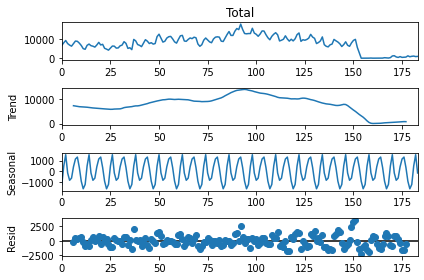

In [7]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

## SARIMAX

### Train-Test Split

In [8]:
# Use 90% of the data as the training data
size = len(palau)
train_size = int(0.9*size)
train, test = model_selection.train_test_split(
    palau[["Date", "Total", "covid"]], train_size=165)

### Stepwise searching

In [9]:
stepwise_fit = auto_arima(train["Total"], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2638.685, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2882.120, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2663.036, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2780.658, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2885.637, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2693.408, Time=0.06 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=2633.088, Time=1.20 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=2782.455, Time=0.63 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=2641.248, Time=1.70 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=2885.512, Time=0.40 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : 

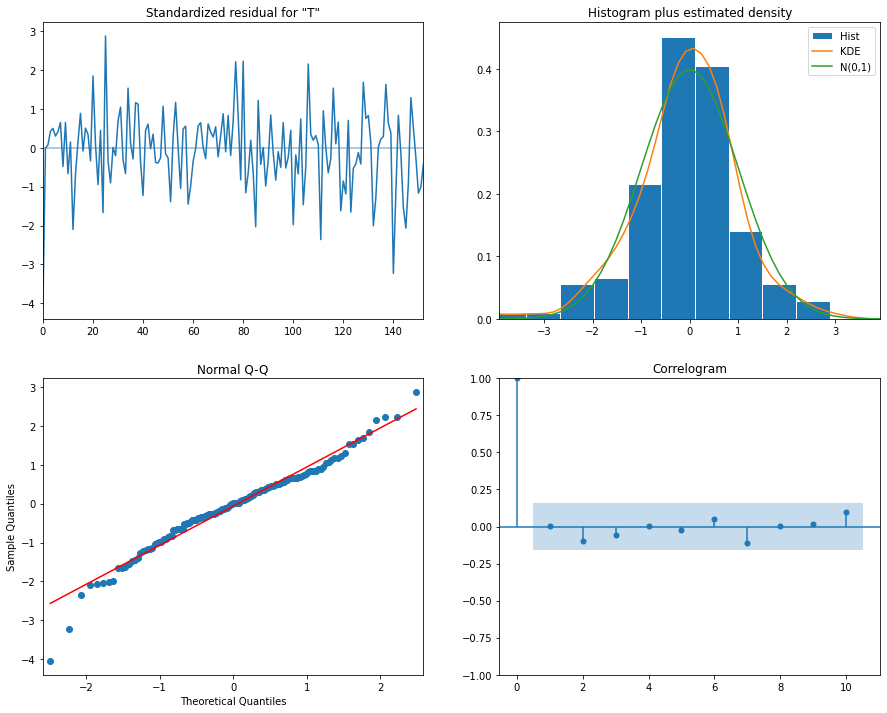

Ljung-box p-values:
[0.93226934 0.46366161 0.57268288 0.73529583 0.83727096 0.86852882
 0.72562585 0.81313924 0.87385096 0.80740326 0.81598974 0.78514178
 0.83691947 0.88310185 0.86297385 0.89422236 0.87981409 0.89928123
 0.79023513 0.81111922 0.83572042 0.87227998 0.9026143  0.92509869]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 Total   No. Observations:                  165
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1303.999
Date:                               Mon, 27 Feb 2023   AIC                           2619.998
Time:                                       21:53:31   BIC                           2638.180
Sample:                                            0   HQIC                          2627.384
                                               - 165                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid        -68.9618     17.135     -4.025      0.000    -102.546     -35.378
ar.L1          0.9977      0.014     69.215      0.000       0.969       1.026
ma.L1         -0.2758      0.089     -3.100      0.002      -0.450      -0.101
ma.S.L12      -0.9493      0.112     -8.489      0.000      -1.169      -0.730
ma.S.L24      -0.0143      0.080     -0.178      0.859      -0.172       0.143
sigma2      1.265e+06      0.000   3.05e+09      0.000    1.27e+06    1.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.34
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.47
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+25. Standard errors may be unstable.
"""

In [10]:
# Use the best model from the stepwise searching
arma_mod = ARIMA(train["Total"], exog=train["covid"],
                 order=(1, 0, 1), seasonal_order=(0, 1, 2, 12))
arma_res = arma_mod.fit()
arma_res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" +
      str(arma_res.test_serial_correlation(method='ljungbox')[0][1]))
arma_res.summary()

In [11]:
def sarimax(series, exog, all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(series,
                          exog=exog,
                          order=param[0],
                          seasonal_order=param[1],
                          return_ssm=False)
            res = mod.fit()
            results.append((res, res.aic, param))
            print(
                'Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic, 2)))
        except Exception as e:
            print(e)
            continue
    return results

In [12]:
## Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

## list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

## Search the minimim aic 
all_res = sarimax(train["Total"], train["covid"], all_param)
all_res.sort(key=lambda x: x[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26031D+01    |proj g|=  8.40092D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   8.401D-06   1.260D+01
  F =   12.603052992196918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:4163.01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.02597D+01    |proj g|=  1.59225D-02

At iterate   25    f=  1.02583D+01    |proj g|=  8.07974D-05

At iterate   30    f=  1.02583D+01    |proj g|=  1.95828D-03

At iterate   35    f=  1.02559D+01    |proj g|=  2.15040D-02

At iterate   40    f=  1.00789D+01    |proj g|=  3.20230D-02

At iterate   45    f=  9.80313D+00    |proj g|=  7.54542D-03

At iterate   50    f=  9.80038D+00    |proj g|=  1.16785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   1.168D-05   9.800D+00
  F =   9.8003848279939305     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.45930D+00    |proj g|=  1.36029D-04

At iterate   10    f=  8.45929D+00    |proj g|=  5.37798D-03

At iterate   15    f=  8.45854D+00    |proj g|=  1.48189D-02

At iterate   20    f=  8.45841D+00    |proj g|=  2.63227D-04

At iterate   25    f=  8.45831D+00    |proj g|=  5.17422D-03

At iterate   30    f=  8.45049D+00    |proj g|=  5.84398D-02

At iterate   35    f=  8.43137D+00    |proj g|=  1.07013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     41      1     0     0   1.292D-06   8.431D+00
  F =   8.4313711692099478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  9.19290D+00    |proj g|=  1.63435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     60      1     0     0   2.449D-05   9.193D+00
  F =   9.1929036487833073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:3041.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78726D+00    |proj g|=  8.60351D-01

At iterate    5    f=  9.51420D+00    |proj g|=  2.33273D-03

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  9.35955D+00    |proj g|=  4.55434D-03

At iterate   35    f=  9.27096D+00    |proj g|=  5.93324D-02

At iterate   40    f=  9.22086D+00    |proj g|=  1.23637D-02

At iterate   45    f=  9.21385D+00    |proj g|=  1.43481D-03

At iterate   50    f=  9.20746D+00    |proj g|=  4.45588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   4.456D-02   9.207D+00
  F =   9.2074580347203554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:3048.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     49      1     0     0   1.174D-05   8.433D+00
  F =   8.4327039991183756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2790.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45803D+00    |proj g|=  1.18475D-01

At iterate    5    f=  8.44834D+00    |proj g|=  4.67470D-02

At iterate   10    f=  8.44201D+00    |proj g|=  1.50799D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  8.44199D+00    |proj g|=  7.44632D-04

At iterate   20    f=  8.44160D+00    |proj g|=  1.06209D-02

At iterate   25    f=  8.44073D+00    |proj g|=  4.20127D-03

At iterate   30    f=  8.44070D+00    |proj g|=  6.59669D-04

At iterate   35    f=  8.43941D+00    |proj g|=  6.87758D-03

At iterate   40    f=  8.41444D+00    |proj g|=  1.36963D-02

At iterate   45    f=  8.41418D+00    |proj g|=  5.20280D-04

At iterate   50    f=  8.41041D+00    |proj g|=  9.48884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   9.489D-03   8.410D+00
  F =   8.41041496166

 This problem is unconstrained.



At iterate   40    f=  9.19486D+00    |proj g|=  2.07500D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     48      1     0     0   4.689D-05   9.195D+00
  F =   9.1948575874443215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:3042.3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49901D+00    |proj g|=  4.83769D-02

At iterate    5    f=  9.49699D+00    |proj g|=  4.54456D-03

At iterate   10

 This problem is unconstrained.



At iterate   25    f=  9.30458D+00    |proj g|=  2.67522D-03

At iterate   30    f=  9.30223D+00    |proj g|=  4.66672D-03

At iterate   35    f=  9.23105D+00    |proj g|=  7.07031D-03

At iterate   40    f=  9.20340D+00    |proj g|=  1.45932D-03

At iterate   45    f=  9.20006D+00    |proj g|=  3.32319D-04

At iterate   50    f=  9.20006D+00    |proj g|=  1.29744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     83      1     0     0   1.297D-04   9.200D+00
  F =   9.2000561313688021     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:3046

 This problem is unconstrained.



At iterate   20    f=  9.48556D+00    |proj g|=  1.27196D-02

At iterate   25    f=  9.40594D+00    |proj g|=  6.42530D-02

At iterate   30    f=  9.36087D+00    |proj g|=  5.23361D-03

At iterate   35    f=  9.35708D+00    |proj g|=  2.50651D-02

At iterate   40    f=  9.35509D+00    |proj g|=  8.44273D-03

At iterate   45    f=  9.35457D+00    |proj g|=  2.74654D-04

At iterate   50    f=  9.35455D+00    |proj g|=  9.63492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   9.635D-04   9.355D+00
  F =   9.3545527791138294     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  8.42738D+00    |proj g|=  1.76189D-02

At iterate   15    f=  8.42665D+00    |proj g|=  5.09873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   5.574D-05   8.427D+00
  F =   8.4266451857415152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2788.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43658D+00    |proj g|=  1.80993D-01

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.41514D+00    |proj g|=  5.96741D-03

At iterate   25    f=  8.41416D+00    |proj g|=  3.53057D-03

At iterate   30    f=  8.41414D+00    |proj g|=  1.54983D-04

At iterate   35    f=  8.41410D+00    |proj g|=  3.22151D-03

At iterate   40    f=  8.40967D+00    |proj g|=  3.32030D-02

At iterate   45    f=  8.40404D+00    |proj g|=  1.17528D-02

At iterate   50    f=  8.40308D+00    |proj g|=  2.30814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   2.308D-05   8.403D+00
  F =   8.4030785040943368     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.41923D+00    |proj g|=  9.23769D-03

At iterate   20    f=  8.41922D+00    |proj g|=  2.63718D-04

At iterate   25    f=  8.41919D+00    |proj g|=  1.33191D-02

At iterate   30    f=  8.41789D+00    |proj g|=  4.77523D-02

At iterate   35    f=  8.41732D+00    |proj g|=  1.85851D-03

At iterate   40    f=  8.41731D+00    |proj g|=  5.07401D-04

At iterate   45    f=  8.41729D+00    |proj g|=  8.53134D-03

At iterate   50    f=  8.41582D+00    |proj g|=  4.91660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   4.917D-02   8.416D+00
  F =   8.41582479997

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  9.50013D+00    |proj g|=  3.09789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     73      1     1     0   3.098D-03   9.500D+00
  F =   9.5001295608051031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:3143.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02182D+01    |proj g|=  2.69180D-01

At iterate    5    f=  1.01134D+01    |proj g|=  6.07588D-03

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  1.00832D+01    |proj g|=  2.95446D-04

At iterate   35    f=  1.00830D+01    |proj g|=  1.74239D-03

At iterate   40    f=  1.00763D+01    |proj g|=  3.36276D-02

At iterate   45    f=  9.70602D+00    |proj g|=  2.86410D-01

At iterate   50    f=  9.39926D+00    |proj g|=  2.22521D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   2.225D-02   9.399D+00
  F =   9.3992594780213210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:3111.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.24703D+00    |proj g|=  7.20944D-03

At iterate   15    f=  8.24375D+00    |proj g|=  2.71931D-02

At iterate   20    f=  8.24294D+00    |proj g|=  4.38626D-04

At iterate   25    f=  8.24114D+00    |proj g|=  1.21874D-02

At iterate   30    f=  8.22250D+00    |proj g|=  1.11354D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     36      1     0     0   1.859D-06   8.222D+00
  F =   8.2215025025986144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:2719.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate   15    f=  8.21907D+00    |proj g|=  2.44637D-02

At iterate   20    f=  8.21707D+00    |proj g|=  2.62552D-04

At iterate   25    f=  8.21702D+00    |proj g|=  5.78028D-03

At iterate   30    f=  8.21112D+00    |proj g|=  6.16162D-02

At iterate   35    f=  8.18116D+00    |proj g|=  5.91461D-03

At iterate   40    f=  8.18112D+00    |proj g|=  1.97928D-03

At iterate   45    f=  8.18111D+00    |proj g|=  1.53170D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     49      1     0     0   1.532D-05   8.181D+00
  F =   8.1811094883647986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.00948D+01    |proj g|=  5.54015D-03

At iterate   10    f=  1.00933D+01    |proj g|=  1.01614D-04

At iterate   15    f=  1.00928D+01    |proj g|=  6.19525D-03

At iterate   20    f=  1.00817D+01    |proj g|=  2.84325D-02

At iterate   25    f=  1.00677D+01    |proj g|=  2.91870D-03

At iterate   30    f=  1.00676D+01    |proj g|=  5.58294D-04

At iterate   35    f=  1.00634D+01    |proj g|=  1.74097D-02

At iterate   40    f=  9.47785D+00    |proj g|=  6.41171D-02

At iterate   45    f=  9.15191D+00    |proj g|=  1.63639D-01

At iterate   50    f=  8.90602D+00    |proj g|=  2.35430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.00676D+01    |proj g|=  2.25500D-03

At iterate   35    f=  1.00674D+01    |proj g|=  3.35485D-04

At iterate   40    f=  1.00670D+01    |proj g|=  7.45190D-03

At iterate   45    f=  1.00151D+01    |proj g|=  6.16584D-02

At iterate   50    f=  9.69483D+00    |proj g|=  7.83298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   7.833D-02   9.695D+00
  F =   9.6948343255913194     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:3211.3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.22589D+00    |proj g|=  1.55173D-04

At iterate   10    f=  8.22585D+00    |proj g|=  5.32681D-03

At iterate   15    f=  8.22234D+00    |proj g|=  5.30356D-02

At iterate   20    f=  8.21271D+00    |proj g|=  5.91769D-04

At iterate   25    f=  8.21243D+00    |proj g|=  1.08811D-02

At iterate   30    f=  8.19741D+00    |proj g|=  6.20893D-02

At iterate   35    f=  8.19019D+00    |proj g|=  8.10331D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   5.950D-06   8.190D+00
  F =   8.1901941545670010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23592D+00    |proj g|=  1.64022D-01

At iterate    5    f=  8.21589D+00    |proj g|=  3.18142D-02

At iterate   10    f=  8.21123D+00    |proj g|=  2.09051D-03

At iterate   15    f=  8.21122D+00    |proj g|=  2.03642D-04

At iterate   20    f=  8.21111D+00    |proj g|=  9.26026D-03

At iterate   25    f=  8.20861D+00    |proj g|=  1.77700D-02

At iterate   30    f=  8.20784D+00    |proj g|=  5.06719D-04

At iterate   35    f=  8.20723D+00    |proj g|=  8.80320D-03

At iterate   40    f=  8.17882D+00    |proj g|=  7.07088D-03

At iterate   45    f=  8.17516D+00    |proj g|=  1.79862D-02

At iterate   50    f=  8.16882D+00    |proj g|=  4.49103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   30    f=  1.00690D+01    |proj g|=  1.40260D-03

At iterate   35    f=  1.00652D+01    |proj g|=  1.40842D-02

At iterate   40    f=  9.64751D+00    |proj g|=  8.30527D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     56      1     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate   30    f=  1.00738D+01    |proj g|=  2.22943D-03

At iterate   35    f=  1.00737D+01    |proj g|=  8.44410D-04

At iterate   40    f=  1.00730D+01    |proj g|=  9.31165D-03

At iterate   45    f=  1.00669D+01    |proj g|=  6.75884D-03

At iterate   50    f=  1.00655D+01    |proj g|=  6.05235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   6.052D-04   1.007D+01
  F =   10.065489791350526     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:3333.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  1.00941D+01    |proj g|=  7.86336D-03

At iterate   10    f=  1.00932D+01    |proj g|=  1.08903D-04

At iterate   15    f=  1.00931D+01    |proj g|=  1.69822D-03

At iterate   20    f=  1.00928D+01    |proj g|=  9.86189D-04

At iterate   25    f=  1.00927D+01    |proj g|=  8.45792D-04

At iterate   30    f=  1.00925D+01    |proj g|=  1.46865D-03

At iterate   35    f=  1.00919D+01    |proj g|=  6.95865D-03

At iterate   40    f=  1.00687D+01    |proj g|=  4.17345D-03

At iterate   45    f=  1.00677D+01    |proj g|=  1.34298D-03

At iterate   50    f=  9.87285D+00    |proj g|=  2.17751D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.21134D+00    |proj g|=  3.20619D-02

At iterate   20    f=  8.20946D+00    |proj g|=  2.89556D-04

At iterate   25    f=  8.20934D+00    |proj g|=  6.08757D-03

At iterate   30    f=  8.19676D+00    |proj g|=  7.95179D-02

At iterate   35    f=  8.16686D+00    |proj g|=  3.08994D-03

At iterate   40    f=  8.16684D+00    |proj g|=  6.64002D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     45      1     0     0   6.640D-07   8.167D+00
  F =   8.1668385738645330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:2705

 This problem is unconstrained.



At iterate   15    f=  8.20799D+00    |proj g|=  3.67055D-03

At iterate   20    f=  8.20795D+00    |proj g|=  8.51165D-04

At iterate   25    f=  8.20739D+00    |proj g|=  1.49579D-02

At iterate   30    f=  8.20433D+00    |proj g|=  9.66055D-03

At iterate   35    f=  8.20419D+00    |proj g|=  7.58987D-04

At iterate   40    f=  8.20347D+00    |proj g|=  6.73425D-03

At iterate   45    f=  8.18201D+00    |proj g|=  1.47899D-02

At iterate   50    f=  8.16873D+00    |proj g|=  4.45672D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   4.457D-02   8.169D+00
  F =   8.16873481909

 This problem is unconstrained.



At iterate   10    f=  8.19969D+00    |proj g|=  1.26847D-02

At iterate   15    f=  8.19833D+00    |proj g|=  1.69457D-03

At iterate   20    f=  8.19831D+00    |proj g|=  7.69498D-04

At iterate   25    f=  8.19712D+00    |proj g|=  3.12554D-02

At iterate   30    f=  8.19365D+00    |proj g|=  1.53108D-02

At iterate   35    f=  8.19349D+00    |proj g|=  1.34098D-03

At iterate   40    f=  8.19348D+00    |proj g|=  2.36180D-03

At iterate   45    f=  8.19276D+00    |proj g|=  8.08339D-03

At iterate   50    f=  8.17654D+00    |proj g|=  1.32910D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.00201D+01    |proj g|=  4.49979D-02

At iterate   40    f=  9.85047D+00    |proj g|=  2.87298D-02

At iterate   45    f=  9.83443D+00    |proj g|=  1.10515D-02

At iterate   50    f=  9.83402D+00    |proj g|=  2.12845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   2.128D-03   9.834D+00
  F =   9.8340181012940384     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:3255.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  1.00889D+01    |proj g|=  1.01398D-04

At iterate   20    f=  1.00888D+01    |proj g|=  1.72046D-03

At iterate   25    f=  1.00793D+01    |proj g|=  2.74267D-02

At iterate   30    f=  1.00045D+01    |proj g|=  7.67359D-02

At iterate   35    f=  9.98926D+00    |proj g|=  5.55241D-02

At iterate   40    f=  9.98893D+00    |proj g|=  1.96761D-02

At iterate   45    f=  9.92140D+00    |proj g|=  1.24445D-01

At iterate   50    f=  9.86684D+00    |proj g|=  8.77730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   8.777D-03   9.867D+00
  F =   9.86684286948

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.20079D+00    |proj g|=  2.05687D-04

At iterate   10    f=  8.20052D+00    |proj g|=  1.25186D-02

At iterate   15    f=  8.19652D+00    |proj g|=  1.45559D-02

At iterate   20    f=  8.19623D+00    |proj g|=  1.58326D-03

At iterate   25    f=  8.19346D+00    |proj g|=  2.54058D-02

At iterate   30    f=  8.16027D+00    |proj g|=  4.53295D-02

At iterate   35    f=  8.15931D+00    |proj g|=  3.14024D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     40      1     0     0   3.140D-06   8.159D+00
  F =   8.1593092790373039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.16383D+00    |proj g|=  7.07612D-04

At iterate   10    f=  8.16382D+00    |proj g|=  9.58731D-04

At iterate   15    f=  8.16314D+00    |proj g|=  1.60687D-02

At iterate   20    f=  8.12803D+00    |proj g|=  1.72442D-01

At iterate   25    f=  8.10625D+00    |proj g|=  5.68460D-04

At iterate   30    f=  8.10607D+00    |proj g|=  8.41725D-03

At iterate   35    f=  8.09903D+00    |proj g|=  2.83759D-02

At iterate   40    f=  8.09640D+00    |proj g|=  3.15456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     45      1     0     0   2.442D-05   8.096D+00
  F =   8.09639914955

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.00830D+01    |proj g|=  4.46740D-03

At iterate   10    f=  1.00810D+01    |proj g|=  7.16789D-04

At iterate   15    f=  1.00810D+01    |proj g|=  4.51243D-04

At iterate   20    f=  1.00803D+01    |proj g|=  5.84230D-03

At iterate   25    f=  1.00290D+01    |proj g|=  7.93973D-03

At iterate   30    f=  1.00045D+01    |proj g|=  1.44978D-02

At iterate   35    f=  1.00025D+01    |proj g|=  6.11269D-04

At iterate   40    f=  9.98572D+00    |proj g|=  5.12311D-02

At iterate   45    f=  9.96975D+00    |proj g|=  7.44830D-03

At iterate   50    f=  9.96947D+00    |proj g|=  4.57287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.00827D+01    |proj g|=  6.95035D-03

At iterate   10    f=  1.00809D+01    |proj g|=  9.02309D-04

At iterate   15    f=  1.00809D+01    |proj g|=  6.53482D-04

At iterate   20    f=  1.00807D+01    |proj g|=  1.30125D-03

At iterate   25    f=  1.00340D+01    |proj g|=  2.75180D-02

At iterate   30    f=  1.00078D+01    |proj g|=  4.60984D-03
  ys=-1.322E-03  -gs= 5.971E-03 BFGS update SKIPPED

At iterate   35    f=  9.99389D+00    |proj g|=  4.91108D-03

At iterate   40    f=  9.99317D+00    |proj g|=  1.06740D-03

At iterate   45    f=  9.99285D+00    |proj g|=  2.74922D-03

At iterate   50    f=  9.98950D+00    |proj g|=  1.59687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   20    f=  8.15439D+00    |proj g|=  1.37175D-02

At iterate   25    f=  8.15415D+00    |proj g|=  1.06729D-03

At iterate   30    f=  8.15354D+00    |proj g|=  2.01111D-02

At iterate   35    f=  8.11561D+00    |proj g|=  8.81189D-02

At iterate   40    f=  8.10781D+00    |proj g|=  4.05323D-04

At iterate   45    f=  8.10780D+00    |proj g|=  7.04486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     51      1     0     0   6.682D-06   8.108D+00
  F =   8.1077999939287544     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(1, 1, 0, 12) - AIC:2685

 This problem is unconstrained.



At iterate   10    f=  8.16413D+00    |proj g|=  2.04928D-04

At iterate   15    f=  8.16405D+00    |proj g|=  6.18504D-03

At iterate   20    f=  8.15124D+00    |proj g|=  1.01532D-01

At iterate   25    f=  8.10033D+00    |proj g|=  1.76094D-02

At iterate   30    f=  8.09992D+00    |proj g|=  5.37585D-04

At iterate   35    f=  8.09882D+00    |proj g|=  2.36082D-02

At iterate   40    f=  8.09690D+00    |proj g|=  1.19285D-03

At iterate   45    f=  8.09690D+00    |proj g|=  1.95438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     50      1     0     0   3.060D-05   8.097D+00
  F =   8.09689884318

 This problem is unconstrained.



At iterate   10    f=  8.16057D+00    |proj g|=  7.19089D-03

At iterate   15    f=  8.16040D+00    |proj g|=  5.20490D-04

At iterate   20    f=  8.16040D+00    |proj g|=  1.13165D-03

At iterate   25    f=  8.15987D+00    |proj g|=  1.50209D-02

At iterate   30    f=  8.12993D+00    |proj g|=  9.59505D-02

At iterate   35    f=  8.11599D+00    |proj g|=  1.60040D-03

At iterate   40    f=  8.11544D+00    |proj g|=  1.71911D-02

At iterate   45    f=  8.10679D+00    |proj g|=  7.06227D-02

At iterate   50    f=  8.10299D+00    |proj g|=  2.15780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



At iterate   30    f=  9.96063D+00    |proj g|=  1.32743D-02

At iterate   35    f=  9.95758D+00    |proj g|=  3.21512D-04

At iterate   40    f=  9.95733D+00    |proj g|=  4.63084D-03

At iterate   45    f=  9.88616D+00    |proj g|=  5.48690D-02

At iterate   50    f=  9.72902D+00    |proj g|=  8.97900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   8.979D-02   9.729D+00
  F =   9.7290167633937479     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(2, 0, 0, 12) - AIC:3222.58
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  1.00824D+01    |proj g|=  2.33308D-03

At iterate   10    f=  1.00812D+01    |proj g|=  7.62867D-04

At iterate   15    f=  1.00810D+01    |proj g|=  2.68707D-03

At iterate   20    f=  1.00809D+01    |proj g|=  1.03439D-04

At iterate   25    f=  1.00808D+01    |proj g|=  3.88294D-03

At iterate   30    f=  1.00704D+01    |proj g|=  3.08816D-02

At iterate   35    f=  9.97626D+00    |proj g|=  1.91950D-02

At iterate   40    f=  9.97228D+00    |proj g|=  1.46934D-03

At iterate   45    f=  9.97216D+00    |proj g|=  4.39393D-04

At iterate   50    f=  9.97157D+00    |proj g|=  5.36090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.00819D+01    |proj g|=  5.03381D-03

At iterate   10    f=  1.00810D+01    |proj g|=  1.14152D-03

At iterate   15    f=  1.00809D+01    |proj g|=  1.74022D-03

At iterate   20    f=  1.00725D+01    |proj g|=  2.35326D-02

At iterate   25    f=  1.00452D+01    |proj g|=  5.06090D-03

At iterate   30    f=  1.00382D+01    |proj g|=  5.59232D-03

At iterate   35    f=  1.00366D+01    |proj g|=  2.65723D-03

At iterate   40    f=  1.00206D+01    |proj g|=  4.37721D-02

At iterate   45    f=  1.00104D+01    |proj g|=  4.31195D-03

At iterate   50    f=  1.00101D+01    |proj g|=  1.43028D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.15973D+00    |proj g|=  4.99293D-04

At iterate   10    f=  8.15973D+00    |proj g|=  1.12222D-03

At iterate   15    f=  8.15943D+00    |proj g|=  1.57807D-02

At iterate   20    f=  8.13435D+00    |proj g|=  1.32043D-01

At iterate   25    f=  8.10328D+00    |proj g|=  2.77822D-03

At iterate   30    f=  8.10324D+00    |proj g|=  3.24546D-03

At iterate   35    f=  8.10033D+00    |proj g|=  4.70236D-02

At iterate   40    f=  8.08785D+00    |proj g|=  5.87695D-03

At iterate   45    f=  8.08782D+00    |proj g|=  6.70951D-04

At iterate   50    f=  8.08780D+00    |proj g|=  5.50095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.15884D+00    |proj g|=  8.91824D-04

At iterate   20    f=  8.15850D+00    |proj g|=  1.11105D-02

At iterate   25    f=  8.12323D+00    |proj g|=  1.34990D-01

At iterate   30    f=  8.09356D+00    |proj g|=  1.98323D-03

At iterate   35    f=  8.09354D+00    |proj g|=  6.41644D-04

At iterate   40    f=  8.09331D+00    |proj g|=  1.42884D-02

At iterate   45    f=  8.08737D+00    |proj g|=  2.44231D-02

At iterate   50    f=  8.08631D+00    |proj g|=  1.96486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   1.965D-03   8.086D+00
  F =   8.08631385804

 This problem is unconstrained.



At iterate   10    f=  8.15588D+00    |proj g|=  3.24036D-02

At iterate   15    f=  8.15410D+00    |proj g|=  7.10817D-03

At iterate   20    f=  8.15362D+00    |proj g|=  2.17876D-04

At iterate   25    f=  8.15361D+00    |proj g|=  1.01741D-03

At iterate   30    f=  8.15270D+00    |proj g|=  1.34651D-02

At iterate   35    f=  8.14715D+00    |proj g|=  2.63497D-02

At iterate   40    f=  8.14496D+00    |proj g|=  8.42217D-03

At iterate   45    f=  8.14163D+00    |proj g|=  1.95588D-02

At iterate   50    f=  8.13957D+00    |proj g|=  1.19118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.56510D+00    |proj g|=  1.83378D-02

At iterate   25    f=  8.56475D+00    |proj g|=  6.76701D-04

At iterate   30    f=  8.56464D+00    |proj g|=  1.07477D-02

At iterate   35    f=  8.55937D+00    |proj g|=  4.47340D-02

At iterate   40    f=  8.55804D+00    |proj g|=  6.93888D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     44      1     0     0   6.939D-05   8.558D+00
  F =   8.5580432166674072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC:2832.15
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.85389D+00    |proj g|=  6.57518D-03

At iterate   20    f=  7.84926D+00    |proj g|=  9.81358D-04

At iterate   25    f=  7.83373D+00    |proj g|=  1.79500D-02

At iterate   30    f=  7.82644D+00    |proj g|=  2.50860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     37      1     0     0   7.929D-06   7.826D+00
  F =   7.8264382348616151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:2588.72
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.46538D+00    |proj g|=  1.05224D-02

At iterate   15    f=  8.46381D+00    |proj g|=  1.69142D-04

At iterate   20    f=  8.46082D+00    |proj g|=  3.19761D-03

At iterate   25    f=  8.45586D+00    |proj g|=  1.69062D-03

At iterate   30    f=  8.45480D+00    |proj g|=  1.98772D-03

At iterate   35    f=  8.45478D+00    |proj g|=  8.43562D-04

At iterate   40    f=  8.45453D+00    |proj g|=  1.50958D-02

At iterate   45    f=  8.45050D+00    |proj g|=  9.83459D-03

At iterate   50    f=  8.44970D+00    |proj g|=  7.10484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.85189D+00    |proj g|=  5.14151D-03

At iterate   10    f=  7.85185D+00    |proj g|=  2.41066D-03

At iterate   15    f=  7.85094D+00    |proj g|=  2.88661D-02

At iterate   20    f=  7.84394D+00    |proj g|=  1.16284D-03

At iterate   25    f=  7.84390D+00    |proj g|=  3.29422D-04

At iterate   30    f=  7.84200D+00    |proj g|=  3.17059D-02

At iterate   35    f=  7.82497D+00    |proj g|=  2.59041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     41      1     0     0   9.645D-06   7.825D+00
  F =   7.8249706345136971     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   20    f=  7.85308D+00    |proj g|=  2.14964D-03

At iterate   25    f=  7.84988D+00    |proj g|=  6.69191D-03

At iterate   30    f=  7.84689D+00    |proj g|=  3.65552D-04

At iterate   35    f=  7.84648D+00    |proj g|=  4.68195D-03

At iterate   40    f=  7.81203D+00    |proj g|=  5.22138D-03

At iterate   45    f=  7.80974D+00    |proj g|=  1.68143D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     64      1     0     0   1.681D-05   7.810D+00
  F =   7.8097383092274644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:2587

 This problem is unconstrained.


Tried out SARIMAX(0, 1, 0)x(2, 0, 0, 12) - AIC:2813.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47179D+00    |proj g|=  5.11387D-02

At iterate    5    f=  8.46119D+00    |proj g|=  4.01372D-02

At iterate   10    f=  8.45321D+00    |proj g|=  1.32956D-03

At iterate   15    f=  8.45306D+00    |proj g|=  2.75731D-04

At iterate   20    f=  8.45273D+00    |proj g|=  2.84251D-03

At iterate   25    f=  8.45190D+00    |proj g|=  2.10247D-03


 This problem is unconstrained.



At iterate   30    f=  8.45188D+00    |proj g|=  1.14850D-03

At iterate   35    f=  8.45132D+00    |proj g|=  1.36241D-02

At iterate   40    f=  8.44960D+00    |proj g|=  5.11625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     51      1     0     0   7.075D-06   8.450D+00
  F =   8.4495980905580694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(2, 0, 1, 12) - AIC:2798.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.44809D+00    |proj g|=  4.68205D-03

At iterate   20    f=  8.44796D+00    |proj g|=  1.52636D-04

At iterate   25    f=  8.44784D+00    |proj g|=  1.11652D-03

At iterate   30    f=  8.44037D+00    |proj g|=  5.71637D-03

At iterate   35    f=  8.43714D+00    |proj g|=  3.14487D-04

At iterate   40    f=  8.43702D+00    |proj g|=  1.47260D-03

At iterate   45    f=  8.43514D+00    |proj g|=  4.19030D-03

At iterate   50    f=  8.43468D+00    |proj g|=  3.88452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.885D-05   8.435D+00
  F =   8.43468008213

 This problem is unconstrained.



At iterate   10    f=  7.86224D+00    |proj g|=  4.45163D-03

At iterate   15    f=  7.86141D+00    |proj g|=  2.10536D-02

At iterate   20    f=  7.86108D+00    |proj g|=  4.70886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   4.709D-05   7.861D+00
  F =   7.8610836467900285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:2602.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  7.83309D+00    |proj g|=  2.08456D-02

At iterate   25    f=  7.82894D+00    |proj g|=  1.68989D-02

At iterate   30    f=  7.82727D+00    |proj g|=  7.63994D-04

At iterate   35    f=  7.82726D+00    |proj g|=  4.74910D-04

At iterate   40    f=  7.82717D+00    |proj g|=  8.59013D-03

At iterate   45    f=  7.82420D+00    |proj g|=  9.37541D-03

At iterate   50    f=  7.82386D+00    |proj g|=  3.44150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   3.441D-03   7.824D+00
  F =   7.8238577263549374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  7.83569D+00    |proj g|=  4.66650D-04

At iterate   20    f=  7.83564D+00    |proj g|=  1.35855D-03

At iterate   25    f=  7.83349D+00    |proj g|=  2.28046D-02

At iterate   30    f=  7.82887D+00    |proj g|=  1.13539D-02

At iterate   35    f=  7.82841D+00    |proj g|=  1.69183D-04

At iterate   40    f=  7.82808D+00    |proj g|=  4.12021D-03

At iterate   45    f=  7.81745D+00    |proj g|=  1.61513D-02

At iterate   50    f=  7.81118D+00    |proj g|=  3.37602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.376D-02   7.811D+00
  F =   7.81117918263

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.57072D+00    |proj g|=  1.60375D-03

At iterate   15    f=  8.57004D+00    |proj g|=  1.75647D-02

At iterate   20    f=  8.56507D+00    |proj g|=  6.65393D-03

At iterate   25    f=  8.56501D+00    |proj g|=  4.95204D-04

At iterate   30    f=  8.56495D+00    |proj g|=  8.78358D-03

At iterate   35    f=  8.56111D+00    |proj g|=  3.58547D-02

At iterate   40    f=  8.55690D+00    |proj g|=  3.19538D-02

At iterate   45    f=  8.55341D+00    |proj g|=  6.69555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     50      1     0     0   4.192D-06   8.553D+00
  F =   8.55340955436

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.82453D+00    |proj g|=  1.36260D-02

At iterate   30    f=  7.78819D+00    |proj g|=  1.14809D-02

At iterate   35    f=  7.78663D+00    |proj g|=  2.12229D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     41      1     0     0   2.122D-05   7.787D+00
  F =   7.7866288579814951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:2577.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.83741D+00    |proj g|=  4.63017D-03

At iterate   15    f=  7.83014D+00    |proj g|=  4.03811D-02

At iterate   20    f=  7.82549D+00    |proj g|=  3.33856D-04

At iterate   25    f=  7.82486D+00    |proj g|=  4.45569D-03

At iterate   30    f=  7.79386D+00    |proj g|=  9.57396D-02

At iterate   35    f=  7.78483D+00    |proj g|=  1.51317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     43      1     0     0   2.208D-06   7.785D+00
  F =   7.7848257983317612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:2578

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.47354D+00    |proj g|=  5.35932D-03

At iterate   30    f=  8.45787D+00    |proj g|=  2.01119D-03

At iterate   35    f=  8.45770D+00    |proj g|=  3.28341D-03

At iterate   40    f=  8.43963D+00    |proj g|=  5.14715D-02

At iterate   45    f=  8.42540D+00    |proj g|=  3.93897D-03

At iterate   50    f=  8.42485D+00    |proj g|=  3.80380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   3.804D-04   8.425D+00
  F =   8.4248450240777366     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 1)x(1, 0, 1, 12) - AIC:2790

 This problem is unconstrained.



At iterate   10    f=  8.49413D+00    |proj g|=  4.68708D-03

At iterate   15    f=  8.49381D+00    |proj g|=  2.80761D-04

At iterate   20    f=  8.49358D+00    |proj g|=  7.82912D-03

At iterate   25    f=  8.47804D+00    |proj g|=  5.19661D-02

At iterate   30    f=  8.46044D+00    |proj g|=  2.35891D-03

At iterate   35    f=  8.45839D+00    |proj g|=  8.14562D-03

At iterate   40    f=  8.45722D+00    |proj g|=  8.53369D-03

At iterate   45    f=  8.43120D+00    |proj g|=  1.87350D-02

At iterate   50    f=  8.42641D+00    |proj g|=  1.01892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.89915D+00    |proj g|=  4.29119D-03

At iterate   15    f=  7.89704D+00    |proj g|=  3.90022D-02

At iterate   20    f=  7.89356D+00    |proj g|=  2.83549D-04

At iterate   25    f=  7.89352D+00    |proj g|=  3.09840D-03

At iterate   30    f=  7.89037D+00    |proj g|=  2.61449D-02

At iterate   35    f=  7.88623D+00    |proj g|=  3.61451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     41      1     0     0   1.386D-06   7.886D+00
  F =   7.8862308670627845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:2610

 This problem is unconstrained.



At iterate   10    f=  7.82941D+00    |proj g|=  2.62474D-04

At iterate   15    f=  7.82935D+00    |proj g|=  2.30509D-03

At iterate   20    f=  7.82089D+00    |proj g|=  3.07469D-02

At iterate   25    f=  7.81959D+00    |proj g|=  6.18488D-04

At iterate   30    f=  7.81861D+00    |proj g|=  1.51460D-02

At iterate   35    f=  7.81203D+00    |proj g|=  5.70136D-03

At iterate   40    f=  7.81190D+00    |proj g|=  5.73979D-04

At iterate   45    f=  7.80703D+00    |proj g|=  1.42004D-02

At iterate   50    f=  7.76830D+00    |proj g|=  3.19450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.



At iterate   30    f=  8.50984D+00    |proj g|=  3.85934D-02

At iterate   35    f=  8.48217D+00    |proj g|=  3.59230D-02

At iterate   40    f=  8.47923D+00    |proj g|=  4.55851D-03

At iterate   45    f=  8.47895D+00    |proj g|=  4.94024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     52      1     0     0   4.940D-05   8.479D+00
  F =   8.4789498744319012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:2808.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.49381D+00    |proj g|=  2.80506D-04

At iterate   15    f=  8.49371D+00    |proj g|=  2.60522D-03

At iterate   20    f=  8.48394D+00    |proj g|=  2.88738D-02

At iterate   25    f=  8.46884D+00    |proj g|=  1.80322D-03

At iterate   30    f=  8.45857D+00    |proj g|=  1.49756D-02

At iterate   35    f=  8.45799D+00    |proj g|=  6.15049D-04

At iterate   40    f=  8.45639D+00    |proj g|=  2.15576D-02

At iterate   45    f=  8.42698D+00    |proj g|=  3.76198D-03

At iterate   50    f=  8.42644D+00    |proj g|=  1.34633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71   

 This problem is unconstrained.



At iterate    5    f=  8.49308D+00    |proj g|=  2.22642D-02

At iterate   10    f=  8.48926D+00    |proj g|=  2.78045D-03

At iterate   15    f=  8.48856D+00    |proj g|=  3.64955D-04

At iterate   20    f=  8.48851D+00    |proj g|=  2.96257D-03

At iterate   25    f=  8.48385D+00    |proj g|=  2.68100D-02

At iterate   30    f=  8.46009D+00    |proj g|=  1.09912D-02

At iterate   35    f=  8.45591D+00    |proj g|=  5.89039D-03

At iterate   40    f=  8.45556D+00    |proj g|=  6.13975D-04

At iterate   45    f=  8.45401D+00    |proj g|=  6.91503D-03

At iterate   50    f=  8.44716D+00    |proj g|=  1.74282D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  7.84653D+00    |proj g|=  3.78788D-02

At iterate   20    f=  7.82294D+00    |proj g|=  9.06145D-03

At iterate   25    f=  7.82273D+00    |proj g|=  2.68818D-03

At iterate   30    f=  7.82052D+00    |proj g|=  3.41669D-02

At iterate   35    f=  7.81581D+00    |proj g|=  7.15536D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     42      1     0     0   4.380D-05   7.816D+00
  F =   7.8158076425868455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:2589.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  7.83390D+00    |proj g|=  5.64910D-03

At iterate   20    f=  7.82895D+00    |proj g|=  1.34284D-02

At iterate   25    f=  7.82242D+00    |proj g|=  2.51461D-02

At iterate   30    f=  7.82182D+00    |proj g|=  3.30486D-04

At iterate   35    f=  7.82072D+00    |proj g|=  1.50427D-02

At iterate   40    f=  7.78976D+00    |proj g|=  5.69922D-02

At iterate   45    f=  7.78191D+00    |proj g|=  5.08128D-04

At iterate   50    f=  7.78191D+00    |proj g|=  2.06590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   2.066D-04   7.782D+00
  F =   7.78190683948

 This problem is unconstrained.



At iterate   10    f=  7.82845D+00    |proj g|=  6.04099D-03

At iterate   15    f=  7.82814D+00    |proj g|=  2.62810D-04

At iterate   20    f=  7.82806D+00    |proj g|=  3.56038D-03

At iterate   25    f=  7.82357D+00    |proj g|=  1.52810D-02

At iterate   30    f=  7.81445D+00    |proj g|=  2.41715D-02

At iterate   35    f=  7.81196D+00    |proj g|=  5.45805D-03

At iterate   40    f=  7.81120D+00    |proj g|=  1.64335D-03

At iterate   45    f=  7.81103D+00    |proj g|=  4.03441D-03

At iterate   50    f=  7.79622D+00    |proj g|=  7.16499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 2)x(0, 0, 1, 12) - AIC:2821.84
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53607D+00    |proj g|=  7.53539D-02

At iterate    5    f=  8.52750D+00    |proj g|=  4.29946D-04

At iterate   10    f=  8.52747D+00    |proj g|=  3.07622D-03

At iterate   15    f=  8.52530D+00    |proj g|=  3.00052D-02

At iterate   20    f=  8.52064D+00    |proj g|=  2.41146D-03


 This problem is unconstrained.



At iterate   25    f=  8.52063D+00    |proj g|=  7.10315D-04

At iterate   30    f=  8.51956D+00    |proj g|=  1.45347D-02

At iterate   35    f=  8.50537D+00    |proj g|=  3.20170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     43      1     0     0   1.320D-05   8.505D+00
  F =   8.5053440526944488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(0, 0, 2, 12) - AIC:2818.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.83282D+00    |proj g|=  2.52914D-04

At iterate   10    f=  7.83260D+00    |proj g|=  4.33981D-03

At iterate   15    f=  7.82396D+00    |proj g|=  1.14300D-02

At iterate   20    f=  7.81942D+00    |proj g|=  3.28635D-02

At iterate   25    f=  7.81517D+00    |proj g|=  8.22282D-04

At iterate   30    f=  7.81499D+00    |proj g|=  4.78511D-03

At iterate   35    f=  7.79395D+00    |proj g|=  5.52134D-02

At iterate   40    f=  7.78199D+00    |proj g|=  1.43975D-02

At iterate   45    f=  7.78063D+00    |proj g|=  2.62794D-03

At iterate   50    f=  7.77980D+00    |proj g|=  2.39371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.83257D+00    |proj g|=  4.79150D-04

At iterate   10    f=  7.83250D+00    |proj g|=  2.06382D-03

At iterate   15    f=  7.82681D+00    |proj g|=  1.08722D-02

At iterate   20    f=  7.82086D+00    |proj g|=  4.42978D-03

At iterate   25    f=  7.81476D+00    |proj g|=  9.18705D-04

At iterate   30    f=  7.81473D+00    |proj g|=  1.64217D-03

At iterate   35    f=  7.81288D+00    |proj g|=  3.04119D-02

At iterate   40    f=  7.78677D+00    |proj g|=  3.04491D-02

At iterate   45    f=  7.77844D+00    |proj g|=  1.72686D-04

At iterate   50    f=  7.77806D+00    |proj g|=  6.30269D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.45967D+00    |proj g|=  4.29945D-02

At iterate   25    f=  8.44959D+00    |proj g|=  6.52608D-03

At iterate   30    f=  8.44934D+00    |proj g|=  3.63644D-04

At iterate   35    f=  8.44898D+00    |proj g|=  1.02274D-02

At iterate   40    f=  8.42770D+00    |proj g|=  8.24808D-02

At iterate   45    f=  8.41006D+00    |proj g|=  1.90505D-02

At iterate   50    f=  8.40869D+00    |proj g|=  9.72545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   9.725D-03   8.409D+00
  F =   8.4086919805843561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  8.46454D+00    |proj g|=  3.78709D-03

At iterate   15    f=  8.46440D+00    |proj g|=  3.13915D-04

At iterate   20    f=  8.46425D+00    |proj g|=  7.40678D-03

At iterate   25    f=  8.45845D+00    |proj g|=  2.17191D-02

At iterate   30    f=  8.44990D+00    |proj g|=  1.70798D-02

At iterate   35    f=  8.44934D+00    |proj g|=  3.64759D-04

At iterate   40    f=  8.44886D+00    |proj g|=  1.94047D-02

At iterate   45    f=  8.42019D+00    |proj g|=  9.13183D-02

At iterate   50    f=  8.40633D+00    |proj g|=  3.18055D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.



At iterate   35    f=  7.87996D+00    |proj g|=  2.24251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     41      1     0     0   2.931D-05   7.880D+00
  F =   7.8799501806589127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(1, 1, 0, 12) - AIC:2610.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86580D+00    |proj g|=  7.68127D-02

At iterate    5    f=  7.83265D+00    |proj g|=  2.16179D-03

At iterate   1

 This problem is unconstrained.



At iterate   25    f=  7.81536D+00    |proj g|=  1.46015D-02

At iterate   30    f=  7.81482D+00    |proj g|=  3.46374D-03

At iterate   35    f=  7.80360D+00    |proj g|=  6.32500D-02

At iterate   40    f=  7.77882D+00    |proj g|=  4.54909D-04

At iterate   45    f=  7.77873D+00    |proj g|=  3.86735D-03

At iterate   50    f=  7.77849D+00    |proj g|=  5.34673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   5.347D-03   7.778D+00
  F =   7.7784895517835686     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 12) - AIC:2578

 This problem is unconstrained.



At iterate   10    f=  7.82478D+00    |proj g|=  5.89305D-04

At iterate   15    f=  7.82475D+00    |proj g|=  1.20240D-03

At iterate   20    f=  7.82294D+00    |proj g|=  2.21299D-02

At iterate   25    f=  7.80678D+00    |proj g|=  1.21877D-02

At iterate   30    f=  7.80640D+00    |proj g|=  1.28443D-03

At iterate   35    f=  7.80082D+00    |proj g|=  2.47536D-02

At iterate   40    f=  7.79899D+00    |proj g|=  8.01232D-04

At iterate   45    f=  7.79753D+00    |proj g|=  6.39582D-03

At iterate   50    f=  7.79555D+00    |proj g|=  7.78290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     73   

 This problem is unconstrained.



At iterate   25    f=  8.48429D+00    |proj g|=  4.86300D-03

At iterate   30    f=  8.48071D+00    |proj g|=  4.62944D-02

At iterate   35    f=  8.45473D+00    |proj g|=  1.04382D-02

At iterate   40    f=  8.45437D+00    |proj g|=  1.52323D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     43      1     0     0   1.523D-06   8.454D+00
  F =   8.4543695740685560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 0, 0, 12) - AIC:2801.94
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.46443D+00    |proj g|=  2.62967D-03

At iterate   15    f=  8.46440D+00    |proj g|=  1.14464D-03

At iterate   20    f=  8.46343D+00    |proj g|=  2.08604D-02

At iterate   25    f=  8.45133D+00    |proj g|=  3.04089D-02

At iterate   30    f=  8.44939D+00    |proj g|=  1.29407D-03

At iterate   35    f=  8.44930D+00    |proj g|=  1.37897D-03

At iterate   40    f=  8.44831D+00    |proj g|=  1.61789D-02

At iterate   45    f=  8.42407D+00    |proj g|=  6.35744D-02

At iterate   50    f=  8.40852D+00    |proj g|=  3.35119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53   

 This problem is unconstrained.



At iterate    5    f=  8.46233D+00    |proj g|=  2.47713D-02

At iterate   10    f=  8.45926D+00    |proj g|=  4.33336D-03

At iterate   15    f=  8.45830D+00    |proj g|=  3.55398D-03

At iterate   20    f=  8.45825D+00    |proj g|=  4.63276D-04

At iterate   25    f=  8.45793D+00    |proj g|=  9.76911D-03

At iterate   30    f=  8.44747D+00    |proj g|=  2.91274D-02

At iterate   35    f=  8.44227D+00    |proj g|=  5.17086D-03

At iterate   40    f=  8.44183D+00    |proj g|=  1.01822D-03

At iterate   45    f=  8.44181D+00    |proj g|=  1.67558D-03

At iterate   50    f=  8.43957D+00    |proj g|=  3.73484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.84408D+00    |proj g|=  2.78104D-03

At iterate   15    f=  7.84124D+00    |proj g|=  3.17310D-02

At iterate   20    f=  7.80744D+00    |proj g|=  1.57767D-02

At iterate   25    f=  7.80721D+00    |proj g|=  1.74263D-04

At iterate   30    f=  7.80717D+00    |proj g|=  6.78581D-03

At iterate   35    f=  7.80643D+00    |proj g|=  9.54584D-03

At iterate   40    f=  7.80636D+00    |proj g|=  6.51362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     45      1     0     0   1.845D-05   7.806D+00
  F =   7.8063604890322305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.82851D+00    |proj g|=  5.98713D-03

At iterate   20    f=  7.82161D+00    |proj g|=  5.29610D-02

At iterate   25    f=  7.81041D+00    |proj g|=  5.05788D-03

At iterate   30    f=  7.80968D+00    |proj g|=  9.55594D-04

At iterate   35    f=  7.80962D+00    |proj g|=  5.00871D-03

At iterate   40    f=  7.80239D+00    |proj g|=  6.40731D-02

At iterate   45    f=  7.77459D+00    |proj g|=  1.89630D-03

At iterate   50    f=  7.77455D+00    |proj g|=  1.66000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.660D-03   7.775D+00
  F =   7.77454798397

 This problem is unconstrained.



At iterate   10    f=  7.82372D+00    |proj g|=  6.24567D-03

At iterate   15    f=  7.82340D+00    |proj g|=  4.75739D-04

At iterate   20    f=  7.82338D+00    |proj g|=  2.06410D-03

At iterate   25    f=  7.82127D+00    |proj g|=  2.61231D-02

At iterate   30    f=  7.80269D+00    |proj g|=  1.32680D-02

At iterate   35    f=  7.80144D+00    |proj g|=  4.81198D-03

At iterate   40    f=  7.79871D+00    |proj g|=  4.28446D-02

At iterate   45    f=  7.79539D+00    |proj g|=  6.86972D-03

At iterate   50    f=  7.79509D+00    |proj g|=  5.78139D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.66396D+00    |proj g|=  2.08127D-03

At iterate   10    f=  8.66338D+00    |proj g|=  2.32756D-02

At iterate   15    f=  8.66147D+00    |proj g|=  6.90903D-04

At iterate   20    f=  8.66100D+00    |proj g|=  2.00261D-02

At iterate   25    f=  8.64002D+00    |proj g|=  8.62282D-02

At iterate   30    f=  8.62844D+00    |proj g|=  2.40504D-04

At iterate   35    f=  8.62843D+00    |proj g|=  1.02182D-03

At iterate   40    f=  8.62824D+00    |proj g|=  1.64029D-02

At iterate   45    f=  8.62611D+00    |proj g|=  6.05197D-03

At iterate   50    f=  8.62520D+00    |proj g|=  1.93310D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.94533D+00    |proj g|=  2.58283D-03

At iterate   25    f=  7.93975D+00    |proj g|=  3.58606D-04

At iterate   30    f=  7.91927D+00    |proj g|=  2.42107D-03

At iterate   35    f=  7.91882D+00    |proj g|=  2.19925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     45      1     0     0   1.401D-06   7.919D+00
  F =   7.9188176808507027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:2621.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  7.95681D+00    |proj g|=  4.33073D-04

At iterate   15    f=  7.95619D+00    |proj g|=  8.63650D-03

At iterate   20    f=  7.94421D+00    |proj g|=  2.23322D-03

At iterate   25    f=  7.94245D+00    |proj g|=  2.01860D-02

At iterate   30    f=  7.93979D+00    |proj g|=  6.98288D-04

At iterate   35    f=  7.93967D+00    |proj g|=  1.10221D-03

At iterate   40    f=  7.92838D+00    |proj g|=  6.94786D-03
  ys=-2.012E-04  -gs= 5.729E-03 BFGS update SKIPPED

At iterate   45    f=  7.91852D+00    |proj g|=  4.79462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     71      1     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.58417D+00    |proj g|=  1.59265D-02

At iterate   20    f=  8.56415D+00    |proj g|=  3.25561D-02

At iterate   25    f=  8.55112D+00    |proj g|=  2.86235D-03

At iterate   30    f=  8.55071D+00    |proj g|=  2.39967D-03

At iterate   35    f=  8.54322D+00    |proj g|=  4.86123D-02

At iterate   40    f=  8.49287D+00    |proj g|=  1.58624D-02

At iterate   45    f=  8.48795D+00    |proj g|=  1.83489D-03

At iterate   50    f=  8.48765D+00    |proj g|=  1.43782D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   1.438D-05   8.488D+00
  F =   8.48765163848

 This problem is unconstrained.



At iterate   10    f=  8.59132D+00    |proj g|=  5.05027D-03

At iterate   15    f=  8.58968D+00    |proj g|=  9.72394D-03

At iterate   20    f=  8.58705D+00    |proj g|=  2.41487D-02

At iterate   25    f=  8.55136D+00    |proj g|=  1.72949D-02

At iterate   30    f=  8.55077D+00    |proj g|=  2.74550D-04

At iterate   35    f=  8.55052D+00    |proj g|=  1.12278D-02

At iterate   40    f=  8.54675D+00    |proj g|=  1.14798D-02

At iterate   45    f=  8.50655D+00    |proj g|=  5.67795D-02

At iterate   50    f=  8.48892D+00    |proj g|=  1.23839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.



At iterate   15    f=  7.99291D+00    |proj g|=  2.82295D-02

At iterate   20    f=  7.99049D+00    |proj g|=  1.63270D-04

At iterate   25    f=  7.99048D+00    |proj g|=  2.12088D-03

At iterate   30    f=  7.98983D+00    |proj g|=  2.38263D-02

At iterate   35    f=  7.98673D+00    |proj g|=  2.98147D-03

At iterate   40    f=  7.98672D+00    |proj g|=  1.96714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     46      1     0     0   1.515D-04   7.987D+00
  F =   7.9867164869493328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 0)x(1, 1, 0, 12) - AIC:2643

 This problem is unconstrained.



At iterate   10    f=  7.95696D+00    |proj g|=  9.89163D-04

At iterate   15    f=  7.95516D+00    |proj g|=  7.72586D-03

At iterate   20    f=  7.94464D+00    |proj g|=  3.56389D-03

At iterate   25    f=  7.94223D+00    |proj g|=  1.74546D-02

At iterate   30    f=  7.93983D+00    |proj g|=  2.83868D-04

At iterate   35    f=  7.93917D+00    |proj g|=  7.45420D-03

At iterate   40    f=  7.91937D+00    |proj g|=  2.76228D-02

At iterate   45    f=  7.91851D+00    |proj g|=  2.18688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     63      1     0     0   1.607D-06   7.919D+00
  F =   7.91851012776

 This problem is unconstrained.



At iterate   10    f=  7.95346D+00    |proj g|=  6.55170D-03

At iterate   15    f=  7.95144D+00    |proj g|=  5.18397D-04

At iterate   20    f=  7.94952D+00    |proj g|=  2.10797D-03

At iterate   25    f=  7.93881D+00    |proj g|=  7.58527D-04

At iterate   30    f=  7.93741D+00    |proj g|=  2.09525D-03

At iterate   35    f=  7.93646D+00    |proj g|=  2.38869D-04

At iterate   40    f=  7.93559D+00    |proj g|=  4.76351D-03

At iterate   45    f=  7.92881D+00    |proj g|=  2.06585D-03

At iterate   50    f=  7.92767D+00    |proj g|=  2.16259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate   30    f=  8.60136D+00    |proj g|=  5.67025D-02

At iterate   35    f=  8.57880D+00    |proj g|=  8.06799D-04

At iterate   40    f=  8.57875D+00    |proj g|=  8.39479D-04

At iterate   45    f=  8.57771D+00    |proj g|=  1.54231D-02

At iterate   50    f=  8.54543D+00    |proj g|=  1.30857D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.309D-02   8.545D+00
  F =   8.5454251339866651     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:2829.99
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.59163D+00    |proj g|=  1.90274D-02

At iterate   15    f=  8.58903D+00    |proj g|=  3.95829D-03

At iterate   20    f=  8.58837D+00    |proj g|=  5.53469D-03

At iterate   25    f=  8.57408D+00    |proj g|=  3.84832D-03

At iterate   30    f=  8.56819D+00    |proj g|=  6.71975D-03

At iterate   35    f=  8.56295D+00    |proj g|=  3.98264D-02

At iterate   40    f=  8.55072D+00    |proj g|=  4.52572D-04

At iterate   45    f=  8.55064D+00    |proj g|=  2.91009D-03

At iterate   50    f=  8.53646D+00    |proj g|=  5.52419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     82   

 This problem is unconstrained.



At iterate   20    f=  8.58675D+00    |proj g|=  6.02424D-03

At iterate   25    f=  8.58631D+00    |proj g|=  1.17732D-03

At iterate   30    f=  8.58204D+00    |proj g|=  2.23974D-03

At iterate   35    f=  8.57301D+00    |proj g|=  2.74858D-03

At iterate   40    f=  8.55264D+00    |proj g|=  5.68111D-03

At iterate   45    f=  8.55034D+00    |proj g|=  1.28364D-03

At iterate   50    f=  8.54745D+00    |proj g|=  9.15598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   9.156D-03   8.547D+00
  F =   8.5474485905754065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  7.95597D+00    |proj g|=  2.69202D-03

At iterate   10    f=  7.95590D+00    |proj g|=  1.16565D-03

At iterate   15    f=  7.95490D+00    |proj g|=  1.64189D-02

At iterate   20    f=  7.94843D+00    |proj g|=  9.30893D-03

At iterate   25    f=  7.94794D+00    |proj g|=  2.80640D-04

At iterate   30    f=  7.94748D+00    |proj g|=  1.38743D-02

At iterate   35    f=  7.93548D+00    |proj g|=  6.34631D-03

At iterate   40    f=  7.93495D+00    |proj g|=  1.51468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     49      1     0     0   7.785D-06   7.935D+00
  F =   7.93492837254

 This problem is unconstrained.



At iterate   15    f=  7.95308D+00    |proj g|=  3.18941D-03

At iterate   20    f=  7.94319D+00    |proj g|=  2.33570D-02

At iterate   25    f=  7.93807D+00    |proj g|=  2.27850D-03

At iterate   30    f=  7.93790D+00    |proj g|=  1.91144D-04

At iterate   35    f=  7.93787D+00    |proj g|=  1.65756D-03

At iterate   40    f=  7.93691D+00    |proj g|=  7.16960D-03

At iterate   45    f=  7.93450D+00    |proj g|=  1.54919D-02

At iterate   50    f=  7.92786D+00    |proj g|=  1.10923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     52      1     0     0   1.109D-02   7.928D+00
  F =   7.92786144773

 This problem is unconstrained.



At iterate   15    f=  7.94806D+00    |proj g|=  2.01283D-02

At iterate   20    f=  7.94735D+00    |proj g|=  3.83817D-04

At iterate   25    f=  7.94712D+00    |proj g|=  3.51006D-03

At iterate   30    f=  7.93926D+00    |proj g|=  1.69714D-02

At iterate   35    f=  7.93744D+00    |proj g|=  8.74514D-04

At iterate   40    f=  7.93642D+00    |proj g|=  9.41560D-03

At iterate   45    f=  7.93299D+00    |proj g|=  9.32949D-03

At iterate   50    f=  7.93140D+00    |proj g|=  2.66383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   2.664D-03   7.931D+00
  F =   7.93139740406

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  8.63963D+00    |proj g|=  2.95952D-02

At iterate   50    f=  8.63090D+00    |proj g|=  5.53889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   5.539D-04   8.631D+00
  F =   8.6308973594448180     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:2858.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81670D+00    |proj g|=  3.56434D-01

At iterate    5

 This problem is unconstrained.



At iterate   20    f=  8.65894D+00    |proj g|=  1.20071D-02

At iterate   25    f=  8.63464D+00    |proj g|=  8.49821D-02

At iterate   30    f=  8.62042D+00    |proj g|=  2.29251D-04

At iterate   35    f=  8.62041D+00    |proj g|=  5.10075D-04

At iterate   40    f=  8.61966D+00    |proj g|=  1.68299D-02

At iterate   45    f=  8.60889D+00    |proj g|=  1.28691D-02

At iterate   50    f=  8.60505D+00    |proj g|=  1.25389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.254D-02   8.605D+00
  F =   8.6050476608029847     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.94185D+00    |proj g|=  5.62897D-03

At iterate   20    f=  7.93134D+00    |proj g|=  2.86698D-03

At iterate   25    f=  7.92804D+00    |proj g|=  1.72236D-03

At iterate   30    f=  7.92386D+00    |proj g|=  8.55340D-04

At iterate   35    f=  7.92377D+00    |proj g|=  1.88873D-03

At iterate   40    f=  7.91917D+00    |proj g|=  4.85353D-03

At iterate   45    f=  7.90486D+00    |proj g|=  5.12270D-03

At iterate   50    f=  7.90280D+00    |proj g|=  8.51309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   8.513D-03   7.903D+00
  F =   7.90280356363

 This problem is unconstrained.



At iterate   15    f=  7.94231D+00    |proj g|=  5.74600D-03

At iterate   20    f=  7.93111D+00    |proj g|=  2.29152D-02

At iterate   25    f=  7.92621D+00    |proj g|=  1.75570D-02

At iterate   30    f=  7.92374D+00    |proj g|=  5.93349D-04

At iterate   35    f=  7.92362D+00    |proj g|=  1.80853D-04

At iterate   40    f=  7.92335D+00    |proj g|=  9.24392D-03

At iterate   45    f=  7.90842D+00    |proj g|=  2.55441D-02

At iterate   50    f=  7.90302D+00    |proj g|=  2.82592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.826D-03   7.903D+00
  F =   7.90302370070

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.58647D+00    |proj g|=  4.94086D-03

At iterate   10    f=  8.58365D+00    |proj g|=  7.33507D-04

At iterate   15    f=  8.58334D+00    |proj g|=  4.43154D-03

At iterate   20    f=  8.57537D+00    |proj g|=  7.88900D-03

At iterate   25    f=  8.54561D+00    |proj g|=  4.23670D-03

At iterate   30    f=  8.53754D+00    |proj g|=  1.05911D-02

At iterate   35    f=  8.53562D+00    |proj g|=  2.87933D-04

At iterate   40    f=  8.53541D+00    |proj g|=  2.17084D-03

At iterate   45    f=  8.53206D+00    |proj g|=  7.59132D-03

At iterate   50    f=  8.49092D+00    |proj g|=  1.96422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  8.57962D+00    |proj g|=  2.30745D-02

At iterate   30    f=  8.54640D+00    |proj g|=  2.53831D-02

At iterate   35    f=  8.54386D+00    |proj g|=  3.86011D-03

At iterate   40    f=  8.54045D+00    |proj g|=  3.35676D-03

At iterate   45    f=  8.53678D+00    |proj g|=  1.22373D-02

At iterate   50    f=  8.53601D+00    |proj g|=  2.88515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   2.885D-04   8.536D+00
  F =   8.5360133445124582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(1, 0, 2, 12) - AIC:2830

 This problem is unconstrained.



At iterate   20    f=  7.98235D+00    |proj g|=  3.25211D-02

At iterate   25    f=  7.98000D+00    |proj g|=  7.82292D-05

At iterate   30    f=  7.97986D+00    |proj g|=  9.08935D-03

At iterate   35    f=  7.97697D+00    |proj g|=  2.14104D-02

At iterate   40    f=  7.97644D+00    |proj g|=  9.31420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     48      1     0     0   1.805D-05   7.976D+00
  F =   7.9764354318011739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 1)x(1, 1, 0, 12) - AIC:2642.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  7.94283D+00    |proj g|=  2.70691D-03

At iterate   15    f=  7.94260D+00    |proj g|=  7.58624D-04

At iterate   20    f=  7.94140D+00    |proj g|=  1.41966D-02

At iterate   25    f=  7.92475D+00    |proj g|=  1.08886D-02

At iterate   30    f=  7.92372D+00    |proj g|=  6.95232D-04

At iterate   35    f=  7.92369D+00    |proj g|=  4.41252D-04

At iterate   40    f=  7.92341D+00    |proj g|=  8.82440D-03

At iterate   45    f=  7.91327D+00    |proj g|=  2.42922D-02

At iterate   50    f=  7.89963D+00    |proj g|=  1.67843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.



At iterate    5    f=  7.94352D+00    |proj g|=  8.74733D-03

At iterate   10    f=  7.93812D+00    |proj g|=  1.65666D-02

At iterate   15    f=  7.93683D+00    |proj g|=  1.71161D-03

At iterate   20    f=  7.93650D+00    |proj g|=  2.30774D-03

At iterate   25    f=  7.92584D+00    |proj g|=  2.26810D-02

At iterate   30    f=  7.92298D+00    |proj g|=  1.82406D-04

At iterate   35    f=  7.92277D+00    |proj g|=  2.03287D-03

At iterate   40    f=  7.92192D+00    |proj g|=  4.81818D-03

At iterate   45    f=  7.91627D+00    |proj g|=  1.11260D-02

At iterate   50    f=  7.91430D+00    |proj g|=  1.58598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  8.61398D+00    |proj g|=  9.64772D-03

At iterate   30    f=  8.58365D+00    |proj g|=  1.00867D-01

At iterate   35    f=  8.56188D+00    |proj g|=  2.44468D-03

At iterate   40    f=  8.56152D+00    |proj g|=  2.55260D-04

At iterate   45    f=  8.56146D+00    |proj g|=  4.78389D-03

At iterate   50    f=  8.55519D+00    |proj g|=  4.71941D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   4.719D-02   8.555D+00
  F =   8.5551904390744422     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:2835

 This problem is unconstrained.



At iterate   25    f=  8.58156D+00    |proj g|=  8.91040D-03

At iterate   30    f=  8.55492D+00    |proj g|=  3.20810D-02

At iterate   35    f=  8.53914D+00    |proj g|=  4.53119D-03

At iterate   40    f=  8.53753D+00    |proj g|=  1.43411D-02

At iterate   45    f=  8.53603D+00    |proj g|=  1.25171D-03

At iterate   50    f=  8.53600D+00    |proj g|=  1.77370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.774D-03   8.536D+00
  F =   8.5360044721756463     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC:2830

 This problem is unconstrained.



At iterate   10    f=  8.58368D+00    |proj g|=  1.76458D-03

At iterate   15    f=  8.58215D+00    |proj g|=  1.52472D-02

At iterate   20    f=  8.58155D+00    |proj g|=  3.77443D-03

At iterate   25    f=  8.58056D+00    |proj g|=  2.72152D-03

At iterate   30    f=  8.58024D+00    |proj g|=  9.54728D-03

At iterate   35    f=  8.57103D+00    |proj g|=  1.62225D-02

At iterate   40    f=  8.56231D+00    |proj g|=  1.50700D-02

At iterate   45    f=  8.55936D+00    |proj g|=  3.14607D-03

At iterate   50    f=  8.55896D+00    |proj g|=  8.88959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66   

 This problem is unconstrained.



At iterate   10    f=  7.94423D+00    |proj g|=  8.33113D-04

At iterate   15    f=  7.94396D+00    |proj g|=  1.60228D-02

At iterate   20    f=  7.93756D+00    |proj g|=  4.30709D-02

At iterate   25    f=  7.93529D+00    |proj g|=  1.44985D-04

At iterate   30    f=  7.93528D+00    |proj g|=  5.46585D-04

At iterate   35    f=  7.93458D+00    |proj g|=  4.12154D-03

At iterate   40    f=  7.92585D+00    |proj g|=  2.27799D-02

At iterate   45    f=  7.92200D+00    |proj g|=  6.56397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     54      1     0     0   5.350D-06   7.922D+00
  F =   7.92193200457

 This problem is unconstrained.



At iterate   10    f=  7.93923D+00    |proj g|=  3.48118D-03

At iterate   15    f=  7.93915D+00    |proj g|=  7.34572D-04

At iterate   20    f=  7.93842D+00    |proj g|=  9.10626D-03

At iterate   25    f=  7.92843D+00    |proj g|=  6.23815D-03

At iterate   30    f=  7.92446D+00    |proj g|=  3.02669D-02

At iterate   35    f=  7.92106D+00    |proj g|=  2.54535D-03

At iterate   40    f=  7.92094D+00    |proj g|=  1.81838D-04

At iterate   45    f=  7.92093D+00    |proj g|=  1.53469D-03

At iterate   50    f=  7.91972D+00    |proj g|=  1.45622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.



At iterate   10    f=  7.93431D+00    |proj g|=  1.12972D-02

At iterate   15    f=  7.93268D+00    |proj g|=  4.82376D-03

At iterate   20    f=  7.93254D+00    |proj g|=  9.60904D-04

At iterate   25    f=  7.93157D+00    |proj g|=  1.12258D-02

At iterate   30    f=  7.92099D+00    |proj g|=  1.17240D-02

At iterate   35    f=  7.91957D+00    |proj g|=  2.43212D-03

At iterate   40    f=  7.91692D+00    |proj g|=  1.67870D-02

At iterate   45    f=  7.91497D+00    |proj g|=  1.21058D-03

At iterate   50    f=  7.91489D+00    |proj g|=  7.81420D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.63063D+00    |proj g|=  6.62125D-02

At iterate   20    f=  8.62124D+00    |proj g|=  3.03914D-03

At iterate   25    f=  8.61444D+00    |proj g|=  3.89321D-02

At iterate   30    f=  8.59557D+00    |proj g|=  7.77949D-04

At iterate   35    f=  8.59549D+00    |proj g|=  1.98978D-04

At iterate   40    f=  8.59547D+00    |proj g|=  2.21283D-03

At iterate   45    f=  8.59522D+00    |proj g|=  2.91321D-03

At iterate   50    f=  8.59492D+00    |proj g|=  7.47447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   7.474D-03   8.595D+00
  F =   8.59492433940

 This problem is unconstrained.



At iterate    5    f=  8.64178D+00    |proj g|=  1.02394D-02

At iterate   10    f=  8.64151D+00    |proj g|=  4.15163D-03

At iterate   15    f=  8.63923D+00    |proj g|=  2.14773D-02

At iterate   20    f=  8.63797D+00    |proj g|=  4.11781D-03

At iterate   25    f=  8.60598D+00    |proj g|=  2.78306D-02

At iterate   30    f=  8.58971D+00    |proj g|=  1.80191D-03

At iterate   35    f=  8.58872D+00    |proj g|=  1.63053D-02

At iterate   40    f=  8.58303D+00    |proj g|=  2.01587D-02

At iterate   45    f=  8.58248D+00    |proj g|=  1.95008D-03

At iterate   50    f=  8.58246D+00    |proj g|=  2.95081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.93496D+00    |proj g|=  4.10943D-03

At iterate   15    f=  7.93490D+00    |proj g|=  3.48710D-03

At iterate   20    f=  7.93246D+00    |proj g|=  3.47740D-02

At iterate   25    f=  7.92006D+00    |proj g|=  5.30927D-03

At iterate   30    f=  7.91889D+00    |proj g|=  8.36749D-04

At iterate   35    f=  7.91876D+00    |proj g|=  3.51664D-04

At iterate   40    f=  7.91820D+00    |proj g|=  1.00634D-02

At iterate   45    f=  7.90572D+00    |proj g|=  1.33584D-02

At iterate   50    f=  7.89784D+00    |proj g|=  1.90261D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.



At iterate    5    f=  7.93494D+00    |proj g|=  6.36901D-03

At iterate   10    f=  7.93425D+00    |proj g|=  6.78834D-03

At iterate   15    f=  7.93407D+00    |proj g|=  3.23750D-03

At iterate   20    f=  7.93138D+00    |proj g|=  3.62091D-02

At iterate   25    f=  7.91907D+00    |proj g|=  5.59414D-03

At iterate   30    f=  7.91844D+00    |proj g|=  4.52403D-04

At iterate   35    f=  7.91843D+00    |proj g|=  5.70629D-04

At iterate   40    f=  7.91780D+00    |proj g|=  1.30023D-02

At iterate   45    f=  7.89439D+00    |proj g|=  3.05740D-02

At iterate   50    f=  7.89262D+00    |proj g|=  3.73597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:2837.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75895D+00    |proj g|=  3.95474D-01

At iterate    5    f=  8.58058D+00    |proj g|=  3.04663D-03

At iterate   10    f=  8.57792D+00    |proj g|=  2.55373D-03

At iterate   15    f=  8.57621D+00    |proj g|=  7.19938D-03

At iterate   20    f=  8.57406D+00    |proj g|=  8.01736D-04

At iterate   25    f=  8.57326D+00    |proj g|=  8.00527D-03

At iterate   30    f=  8.53082D+00    |proj g|=  5.73605D-02

At iterate   35    f=  8.52053D+00    |proj g|=  1.24070D-03


 This problem is unconstrained.



At iterate   40    f=  8.52050D+00    |proj g|=  6.40173D-04

At iterate   45    f=  8.51999D+00    |proj g|=  7.35633D-03

At iterate   50    f=  8.51383D+00    |proj g|=  2.59620D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   2.596D-02   8.514D+00
  F =   8.5138343510407282     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:2823.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.57878D+00    |proj g|=  1.99718D-03

At iterate   20    f=  8.57709D+00    |proj g|=  2.75577D-02

At iterate   25    f=  8.57412D+00    |proj g|=  3.22917D-03

At iterate   30    f=  8.57401D+00    |proj g|=  3.35616D-03

At iterate   35    f=  8.56456D+00    |proj g|=  5.63169D-02

At iterate   40    f=  8.52392D+00    |proj g|=  8.94220D-03

At iterate   45    f=  8.52254D+00    |proj g|=  1.58855D-02

At iterate   50    f=  8.52048D+00    |proj g|=  1.17205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.172D-03   8.520D+00
  F =   8.52048480984

 This problem is unconstrained.



At iterate   30    f=  7.97822D+00    |proj g|=  6.75155D-04

At iterate   35    f=  7.97794D+00    |proj g|=  8.75793D-03

At iterate   40    f=  7.97427D+00    |proj g|=  1.18921D-02

At iterate   45    f=  7.97410D+00    |proj g|=  1.64954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     50      1     0     0   1.024D-06   7.974D+00
  F =   7.9741035217757847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:2643.45
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  7.93509D+00    |proj g|=  3.03080D-03

At iterate   15    f=  7.93435D+00    |proj g|=  6.49841D-04

At iterate   20    f=  7.93432D+00    |proj g|=  1.26751D-03

At iterate   25    f=  7.93185D+00    |proj g|=  2.49257D-02

At iterate   30    f=  7.92308D+00    |proj g|=  1.04527D-02

At iterate   35    f=  7.92029D+00    |proj g|=  1.03439D-02

At iterate   40    f=  7.91868D+00    |proj g|=  6.34600D-03

At iterate   45    f=  7.91853D+00    |proj g|=  1.89164D-04

At iterate   50    f=  7.91806D+00    |proj g|=  1.22875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

 This problem is unconstrained.



At iterate    5    f=  7.93418D+00    |proj g|=  5.01199D-03

At iterate   10    f=  7.93002D+00    |proj g|=  1.30291D-02

At iterate   15    f=  7.92938D+00    |proj g|=  4.96835D-04

At iterate   20    f=  7.92926D+00    |proj g|=  5.41885D-03

At iterate   25    f=  7.92914D+00    |proj g|=  2.66970D-03

At iterate   30    f=  7.92548D+00    |proj g|=  2.72363D-02

At iterate   35    f=  7.91366D+00    |proj g|=  2.67407D-03

At iterate   40    f=  7.91332D+00    |proj g|=  3.19558D-04

At iterate   45    f=  7.91328D+00    |proj g|=  1.87049D-03

At iterate   50    f=  7.91211D+00    |proj g|=  2.01158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.60398D+00    |proj g|=  2.66864D-02

At iterate   25    f=  8.60278D+00    |proj g|=  8.95598D-04

At iterate   30    f=  8.59725D+00    |proj g|=  5.38462D-02

At iterate   35    f=  8.54667D+00    |proj g|=  2.45337D-02

At iterate   40    f=  8.54521D+00    |proj g|=  5.21620D-03

At iterate   45    f=  8.54507D+00    |proj g|=  2.60523D-04

At iterate   50    f=  8.54504D+00    |proj g|=  3.16783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.168D-03   8.545D+00
  F =   8.5450431049294764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.57657D+00    |proj g|=  6.34546D-03

At iterate   20    f=  8.57548D+00    |proj g|=  1.33553D-02

At iterate   25    f=  8.57394D+00    |proj g|=  3.51070D-03

At iterate   30    f=  8.57360D+00    |proj g|=  6.22437D-03

At iterate   35    f=  8.54921D+00    |proj g|=  4.36750D-02

At iterate   40    f=  8.52179D+00    |proj g|=  5.43328D-03

At iterate   45    f=  8.52076D+00    |proj g|=  9.46969D-03

At iterate   50    f=  8.52047D+00    |proj g|=  2.93136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.931D-04   8.520D+00
  F =   8.52047191681

 This problem is unconstrained.



At iterate    5    f=  8.57978D+00    |proj g|=  5.10297D-03

At iterate   10    f=  8.57774D+00    |proj g|=  1.84377D-03

At iterate   15    f=  8.57539D+00    |proj g|=  1.98383D-02

At iterate   20    f=  8.57276D+00    |proj g|=  5.98280D-03

At iterate   25    f=  8.57244D+00    |proj g|=  4.68585D-03

At iterate   30    f=  8.57169D+00    |proj g|=  7.74158D-03

At iterate   35    f=  8.57071D+00    |proj g|=  3.93350D-03

At iterate   40    f=  8.57051D+00    |proj g|=  1.19915D-03

At iterate   45    f=  8.56997D+00    |proj g|=  5.96800D-03

At iterate   50    f=  8.56741D+00    |proj g|=  5.44914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.93949D+00    |proj g|=  2.40063D-02

At iterate   10    f=  7.93828D+00    |proj g|=  1.30064D-02

At iterate   15    f=  7.93807D+00    |proj g|=  4.23407D-04

At iterate   20    f=  7.93798D+00    |proj g|=  1.05015D-02

At iterate   25    f=  7.93276D+00    |proj g|=  4.68877D-02

At iterate   30    f=  7.93053D+00    |proj g|=  6.08737D-04

At iterate   35    f=  7.93052D+00    |proj g|=  1.54909D-04

At iterate   40    f=  7.93049D+00    |proj g|=  2.75730D-03

At iterate   45    f=  7.92621D+00    |proj g|=  2.58251D-02

At iterate   50    f=  7.91589D+00    |proj g|=  5.58534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.93006D+00    |proj g|=  4.77605D-03

At iterate   15    f=  7.92936D+00    |proj g|=  4.89987D-03

At iterate   20    f=  7.92930D+00    |proj g|=  1.07414D-03

At iterate   25    f=  7.92856D+00    |proj g|=  1.88247D-02

At iterate   30    f=  7.91640D+00    |proj g|=  2.13443D-02

At iterate   35    f=  7.91466D+00    |proj g|=  3.81518D-04

At iterate   40    f=  7.91465D+00    |proj g|=  1.90972D-04

At iterate   45    f=  7.91462D+00    |proj g|=  1.79343D-03

At iterate   50    f=  7.91262D+00    |proj g|=  2.26380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     53   

 This problem is unconstrained.



At iterate   10    f=  7.92484D+00    |proj g|=  7.24659D-03

At iterate   15    f=  7.92466D+00    |proj g|=  7.87157D-04

At iterate   20    f=  7.92454D+00    |proj g|=  4.48719D-04

At iterate   25    f=  7.92430D+00    |proj g|=  6.83461D-03

At iterate   30    f=  7.91686D+00    |proj g|=  2.29702D-02

At iterate   35    f=  7.91508D+00    |proj g|=  8.45222D-03

At iterate   40    f=  7.91258D+00    |proj g|=  2.25612D-02

At iterate   45    f=  7.90966D+00    |proj g|=  2.08384D-03

At iterate   50    f=  7.90963D+00    |proj g|=  2.11014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.57081D+00    |proj g|=  4.50838D-03

At iterate   15    f=  8.56801D+00    |proj g|=  3.61428D-02

At iterate   20    f=  8.56498D+00    |proj g|=  2.06454D-04

At iterate   25    f=  8.56497D+00    |proj g|=  2.91316D-03

At iterate   30    f=  8.56416D+00    |proj g|=  3.49427D-02

At iterate   35    f=  8.55621D+00    |proj g|=  1.04768D-02

At iterate   40    f=  8.55611D+00    |proj g|=  5.68356D-03

At iterate   45    f=  8.55593D+00    |proj g|=  4.26877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     51      1     0     0   1.420D-05   8.556D+00
  F =   8.55592896456

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  7.82428D+00    |proj g|=  1.07405D-02

At iterate   35    f=  7.79876D+00    |proj g|=  2.84407D-04

At iterate   40    f=  7.79876D+00    |proj g|=  1.58416D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     46      1     0     0   1.584D-06   7.799D+00
  F =   7.7987552690932684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2581.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.85241D+00    |proj g|=  1.82677D-03

At iterate   15    f=  7.85042D+00    |proj g|=  2.66037D-02

At iterate   20    f=  7.84188D+00    |proj g|=  4.30789D-03

At iterate   25    f=  7.84139D+00    |proj g|=  9.49205D-04

At iterate   30    f=  7.84116D+00    |proj g|=  1.48991D-02

At iterate   35    f=  7.81892D+00    |proj g|=  1.43066D-01

At iterate   40    f=  7.79736D+00    |proj g|=  1.18980D-03

At iterate   45    f=  7.79710D+00    |proj g|=  4.40310D-04

At iterate   50    f=  7.79707D+00    |proj g|=  6.61014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.44057D+00    |proj g|=  1.42156D-02

At iterate   30    f=  8.43740D+00    |proj g|=  5.14167D-04

At iterate   35    f=  8.43421D+00    |proj g|=  1.96643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   1.652D-05   8.434D+00
  F =   8.4342013707957566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:2793.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.49642D+00    |proj g|=  6.02255D-03

At iterate   25    f=  8.48894D+00    |proj g|=  5.35424D-02

At iterate   30    f=  8.44182D+00    |proj g|=  2.80713D-02

At iterate   35    f=  8.44136D+00    |proj g|=  2.44685D-03

At iterate   40    f=  8.43766D+00    |proj g|=  4.13873D-03

At iterate   45    f=  8.43607D+00    |proj g|=  2.68412D-03

At iterate   50    f=  8.43600D+00    |proj g|=  3.68001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   3.680D-03   8.436D+00
  F =   8.4359966310138184     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  7.91470D+00    |proj g|=  3.90758D-03

At iterate   15    f=  7.91229D+00    |proj g|=  3.53168D-02

At iterate   20    f=  7.90802D+00    |proj g|=  3.16839D-04

At iterate   25    f=  7.90797D+00    |proj g|=  3.39745D-03

At iterate   30    f=  7.90576D+00    |proj g|=  4.19212D-02

At iterate   35    f=  7.90290D+00    |proj g|=  2.84226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   9.202D-06   7.903D+00
  F =   7.9028976126587622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:2615

 This problem is unconstrained.



At iterate   15    f=  7.84723D+00    |proj g|=  4.02197D-02

At iterate   20    f=  7.84146D+00    |proj g|=  2.30789D-04

At iterate   25    f=  7.84126D+00    |proj g|=  5.87306D-03

At iterate   30    f=  7.81795D+00    |proj g|=  9.08010D-02

At iterate   35    f=  7.79737D+00    |proj g|=  1.81191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     42      1     0     0   2.741D-06   7.797D+00
  F =   7.7973663730638165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 1, 12) - AIC:2583.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  7.84583D+00    |proj g|=  3.57571D-03

At iterate   10    f=  7.84468D+00    |proj g|=  2.91127D-04

At iterate   15    f=  7.84450D+00    |proj g|=  4.06743D-03

At iterate   20    f=  7.83881D+00    |proj g|=  1.95843D-02

At iterate   25    f=  7.83768D+00    |proj g|=  7.33180D-03

At iterate   30    f=  7.83430D+00    |proj g|=  2.47160D-02

At iterate   35    f=  7.83141D+00    |proj g|=  3.42673D-03

At iterate   40    f=  7.83124D+00    |proj g|=  1.39899D-03

At iterate   45    f=  7.82891D+00    |proj g|=  1.49506D-02

At iterate   50    f=  7.79421D+00    |proj g|=  8.77494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  8.49333D+00    |proj g|=  1.14566D-02

At iterate   40    f=  8.48968D+00    |proj g|=  1.40205D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     49      1     0     0   3.543D-05   8.489D+00
  F =   8.4894905995994403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:2811.53
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51998D+00    |proj g|=  1.30728D-01

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.49646D+00    |proj g|=  2.22941D-03

At iterate   20    f=  8.48957D+00    |proj g|=  4.10579D-02

At iterate   25    f=  8.46003D+00    |proj g|=  2.10638D-02

At iterate   30    f=  8.44148D+00    |proj g|=  7.02171D-04

At iterate   35    f=  8.44141D+00    |proj g|=  4.49771D-03

At iterate   40    f=  8.44096D+00    |proj g|=  1.04011D-02

At iterate   45    f=  8.43545D+00    |proj g|=  4.67958D-03

At iterate   50    f=  8.43539D+00    |proj g|=  5.28813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   5.288D-04   8.435D+00
  F =   8.43539378503

 This problem is unconstrained.



At iterate   10    f=  8.49252D+00    |proj g|=  3.17013D-03

At iterate   15    f=  8.49150D+00    |proj g|=  6.95298D-03

At iterate   20    f=  8.49132D+00    |proj g|=  3.79783D-04

At iterate   25    f=  8.49109D+00    |proj g|=  3.40527D-03

At iterate   30    f=  8.45145D+00    |proj g|=  6.21814D-02

At iterate   35    f=  8.43689D+00    |proj g|=  1.81722D-02

At iterate   40    f=  8.43329D+00    |proj g|=  1.29477D-02

At iterate   45    f=  8.43260D+00    |proj g|=  1.13998D-03

At iterate   50    f=  8.43240D+00    |proj g|=  1.43165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.



At iterate    5    f=  7.86444D+00    |proj g|=  2.14144D-04

At iterate   10    f=  7.86438D+00    |proj g|=  7.04333D-03

At iterate   15    f=  7.85901D+00    |proj g|=  5.55221D-02

At iterate   20    f=  7.85405D+00    |proj g|=  1.56053D-03

At iterate   25    f=  7.85400D+00    |proj g|=  6.60009D-03

At iterate   30    f=  7.84952D+00    |proj g|=  7.38545D-02

At iterate   35    f=  7.83166D+00    |proj g|=  5.73298D-03

At iterate   40    f=  7.83124D+00    |proj g|=  3.50681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     49      1     0     0   2.474D-06   7.831D+00
  F =   7.83123149286

 This problem is unconstrained.



At iterate   15    f=  7.84955D+00    |proj g|=  1.16422D-03

At iterate   20    f=  7.84877D+00    |proj g|=  1.71640D-02

At iterate   25    f=  7.84350D+00    |proj g|=  2.28417D-02

At iterate   30    f=  7.83815D+00    |proj g|=  1.58468D-03

At iterate   35    f=  7.83814D+00    |proj g|=  1.83359D-03

At iterate   40    f=  7.83716D+00    |proj g|=  3.04730D-02

At iterate   45    f=  7.80139D+00    |proj g|=  8.06461D-02

At iterate   50    f=  7.79510D+00    |proj g|=  1.94637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   1.946D-03   7.795D+00
  F =   7.79510271389

 This problem is unconstrained.



At iterate   10    f=  7.84386D+00    |proj g|=  6.53762D-03

At iterate   15    f=  7.84339D+00    |proj g|=  2.60446D-04

At iterate   20    f=  7.84337D+00    |proj g|=  2.26121D-03

At iterate   25    f=  7.84213D+00    |proj g|=  1.19829D-02

At iterate   30    f=  7.83497D+00    |proj g|=  1.44554D-03

At iterate   35    f=  7.83330D+00    |proj g|=  3.14855D-02

At iterate   40    f=  7.83048D+00    |proj g|=  2.73759D-03

At iterate   45    f=  7.83042D+00    |proj g|=  6.00044D-04

At iterate   50    f=  7.82943D+00    |proj g|=  9.44595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(1, 1, 1)x(0, 0, 1, 12) - AIC:2826.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56855D+00    |proj g|=  9.96928D-02

At iterate    5    f=  8.56021D+00    |proj g|=  3.25593D-02

At iterate   10    f=  8.53314D+00    |proj g|=  3.70491D-02

At iterate   15    f=  8.53010D+00    |proj g|=  1.24768D-03


 This problem is unconstrained.



At iterate   20    f=  8.53008D+00    |proj g|=  1.01820D-03

At iterate   25    f=  8.52879D+00    |proj g|=  8.60997D-03

At iterate   30    f=  8.52535D+00    |proj g|=  2.20928D-02

At iterate   35    f=  8.52508D+00    |proj g|=  1.37311D-04

At iterate   40    f=  8.52500D+00    |proj g|=  6.57765D-03

At iterate   45    f=  8.52060D+00    |proj g|=  6.45833D-02

At iterate   50    f=  8.51406D+00    |proj g|=  1.12714D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.127D-02   8.514D+00
  F =   8.5140574807005187     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.82848D+00    |proj g|=  1.99585D-02

At iterate   20    f=  7.81713D+00    |proj g|=  9.25893D-04

At iterate   25    f=  7.81706D+00    |proj g|=  1.32424D-03

At iterate   30    f=  7.81190D+00    |proj g|=  1.93868D-02

At iterate   35    f=  7.78693D+00    |proj g|=  5.32330D-02

At iterate   40    f=  7.78166D+00    |proj g|=  1.54190D-03

At iterate   45    f=  7.78087D+00    |proj g|=  7.61258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     54      1     0     0   1.862D-06   7.781D+00
  F =   7.7808378583025330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  7.83053D+00    |proj g|=  6.08469D-04

At iterate   15    f=  7.83033D+00    |proj g|=  1.20058D-02

At iterate   20    f=  7.82010D+00    |proj g|=  4.19099D-02

At iterate   25    f=  7.81688D+00    |proj g|=  3.69485D-03

At iterate   30    f=  7.81676D+00    |proj g|=  1.29117D-03

At iterate   35    f=  7.81593D+00    |proj g|=  2.05626D-02

At iterate   40    f=  7.79667D+00    |proj g|=  6.57797D-02

At iterate   45    f=  7.77968D+00    |proj g|=  1.40039D-03

At iterate   50    f=  7.77964D+00    |proj g|=  1.93877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.


Tried out SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:2811.8
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51090D+00    |proj g|=  1.21657D-01

At iterate    5    f=  8.46407D+00    |proj g|=  3.23831D-02

At iterate   10    f=  8.46099D+00    |proj g|=  4.88703D-04

At iterate   15    f=  8.46095D+00    |proj g|=  6.23884D-04

At iterate   20    f=  8.46052D+00    |proj g|=  8.41256D-03

At iterate   25    f=  8.44550D+00    |proj g|=  1.96790D-02

At iterate   30    f=  8.44446D+00    |proj g|=  5.46304D-04

At iterate   35    f=  8.44350D+00    |proj g|=  4.71879D-03

At iterate   40    f=  8.41622D+00    |proj g|=  4.59419D-02

At iterate   45    f=  8.40837D+00    |proj g|=  3.23285D-03


 This problem is unconstrained.



At iterate   50    f=  8.40801D+00    |proj g|=  5.12764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   5.128D-04   8.408D+00
  F =   8.4080054703609015     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:2786.64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54573D+00    |proj g|=  2.19662D-01

At iterate    5    f=  8.49528D+00    |proj g|=  8.72536D-02

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.46098D+00    |proj g|=  3.58208D-04

At iterate   25    f=  8.46068D+00    |proj g|=  8.31021D-03

At iterate   30    f=  8.45015D+00    |proj g|=  3.14088D-02

At iterate   35    f=  8.44451D+00    |proj g|=  5.71871D-04

At iterate   40    f=  8.44426D+00    |proj g|=  5.04931D-03

At iterate   45    f=  8.43183D+00    |proj g|=  5.12548D-02

At iterate   50    f=  8.41187D+00    |proj g|=  1.02233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.022D-02   8.412D+00
  F =   8.4118717024835199     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  7.88971D+00    |proj g|=  2.81416D-02

At iterate   25    f=  7.88821D+00    |proj g|=  2.62443D-04

At iterate   30    f=  7.88813D+00    |proj g|=  4.45195D-03

At iterate   35    f=  7.88490D+00    |proj g|=  3.09679D-02

At iterate   40    f=  7.88133D+00    |proj g|=  5.36682D-04

At iterate   45    f=  7.88132D+00    |proj g|=  1.22782D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     49      1     0     0   1.228D-06   7.881D+00
  F =   7.8813237772406959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:2610

 This problem is unconstrained.



At iterate   10    f=  7.83059D+00    |proj g|=  2.48073D-04

At iterate   15    f=  7.83019D+00    |proj g|=  6.06030D-03

At iterate   20    f=  7.81931D+00    |proj g|=  1.52738D-02

At iterate   25    f=  7.81684D+00    |proj g|=  3.85169D-04

At iterate   30    f=  7.81664D+00    |proj g|=  3.34950D-03

At iterate   35    f=  7.80591D+00    |proj g|=  1.54627D-02

At iterate   40    f=  7.78313D+00    |proj g|=  4.39633D-02

At iterate   45    f=  7.77987D+00    |proj g|=  5.43461D-04

At iterate   50    f=  7.77966D+00    |proj g|=  9.21153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.



At iterate    5    f=  7.82358D+00    |proj g|=  4.35115D-03

At iterate   10    f=  7.82258D+00    |proj g|=  2.64118D-04

At iterate   15    f=  7.82236D+00    |proj g|=  2.61881D-03

At iterate   20    f=  7.81071D+00    |proj g|=  1.95410D-02

At iterate   25    f=  7.80974D+00    |proj g|=  1.86182D-03

At iterate   30    f=  7.80519D+00    |proj g|=  7.03981D-03

At iterate   35    f=  7.80244D+00    |proj g|=  3.65830D-03

At iterate   40    f=  7.80167D+00    |proj g|=  7.03509D-04

At iterate   45    f=  7.80149D+00    |proj g|=  3.42261D-03

At iterate   50    f=  7.79263D+00    |proj g|=  2.45088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  8.48637D+00    |proj g|=  7.38097D-03

At iterate   30    f=  8.48381D+00    |proj g|=  1.91628D-02

At iterate   35    f=  8.48320D+00    |proj g|=  1.96849D-04

At iterate   40    f=  8.48315D+00    |proj g|=  4.68928D-03

At iterate   45    f=  8.47753D+00    |proj g|=  4.83015D-02

At iterate   50    f=  8.45761D+00    |proj g|=  2.75780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   2.758D-03   8.458D+00
  F =   8.4576135900469041     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 0, 12) - AIC:2803

 This problem is unconstrained.



At iterate   20    f=  8.46097D+00    |proj g|=  6.95741D-04

At iterate   25    f=  8.46063D+00    |proj g|=  1.21556D-02

At iterate   30    f=  8.45158D+00    |proj g|=  3.24099D-02

At iterate   35    f=  8.44749D+00    |proj g|=  3.16575D-03

At iterate   40    f=  8.44484D+00    |proj g|=  8.62765D-03

At iterate   45    f=  8.44415D+00    |proj g|=  4.21895D-04

At iterate   50    f=  8.44370D+00    |proj g|=  1.00456D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.005D-02   8.444D+00
  F =   8.4437040424475089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.45523D+00    |proj g|=  5.27299D-03

At iterate   20    f=  8.45499D+00    |proj g|=  2.78991D-04

At iterate   25    f=  8.45493D+00    |proj g|=  2.18176D-03

At iterate   30    f=  8.45117D+00    |proj g|=  6.64246D-03

At iterate   35    f=  8.44929D+00    |proj g|=  4.16164D-03

At iterate   40    f=  8.44336D+00    |proj g|=  3.07850D-02

At iterate   45    f=  8.43941D+00    |proj g|=  2.34501D-03

At iterate   50    f=  8.43746D+00    |proj g|=  2.40732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.407D-03   8.437D+00
  F =   8.43745644833

 This problem is unconstrained.



At iterate   10    f=  7.84226D+00    |proj g|=  2.19256D-04

At iterate   15    f=  7.84217D+00    |proj g|=  4.95825D-03

At iterate   20    f=  7.83461D+00    |proj g|=  3.98459D-02

At iterate   25    f=  7.81442D+00    |proj g|=  5.55317D-02

At iterate   30    f=  7.80985D+00    |proj g|=  1.76440D-03

At iterate   35    f=  7.80982D+00    |proj g|=  2.99408D-03

At iterate   40    f=  7.80869D+00    |proj g|=  2.33412D-02

At iterate   45    f=  7.80786D+00    |proj g|=  5.89868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58      1     0     0   6.918D-05   7.808D+00
  F =   7.80786386463

 This problem is unconstrained.



At iterate   15    f=  7.82661D+00    |proj g|=  7.50798D-04

At iterate   20    f=  7.82562D+00    |proj g|=  1.36069D-02

At iterate   25    f=  7.81364D+00    |proj g|=  2.10705D-02

At iterate   30    f=  7.81230D+00    |proj g|=  1.70730D-03

At iterate   35    f=  7.81226D+00    |proj g|=  5.17854D-03

At iterate   40    f=  7.80809D+00    |proj g|=  5.59911D-02

At iterate   45    f=  7.77768D+00    |proj g|=  9.26487D-03

At iterate   50    f=  7.77593D+00    |proj g|=  3.36163D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   3.362D-03   7.776D+00
  F =   7.77593395190

 This problem is unconstrained.



At iterate   10    f=  7.82144D+00    |proj g|=  4.33591D-03

At iterate   15    f=  7.82110D+00    |proj g|=  2.64810D-04

At iterate   20    f=  7.82103D+00    |proj g|=  2.72512D-03

At iterate   25    f=  7.81155D+00    |proj g|=  2.13169D-02

At iterate   30    f=  7.80747D+00    |proj g|=  6.92147D-03

At iterate   35    f=  7.80656D+00    |proj g|=  5.08494D-03

At iterate   40    f=  7.80437D+00    |proj g|=  1.11574D-02

At iterate   45    f=  7.80407D+00    |proj g|=  1.91787D-03

At iterate   50    f=  7.80312D+00    |proj g|=  1.87844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  8.51364D+00    |proj g|=  1.76031D-03

At iterate   50    f=  8.51351D+00    |proj g|=  1.37688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   1.377D-04   8.514D+00
  F =   8.5135108863106463     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:2821.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75499D+00    |proj g|=  5.16403D-01

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.50920D+00    |proj g|=  3.69570D-02

At iterate   25    f=  8.50589D+00    |proj g|=  6.64283D-04

At iterate   30    f=  8.50588D+00    |proj g|=  1.51002D-04

At iterate   35    f=  8.50588D+00    |proj g|=  1.03236D-03

At iterate   40    f=  8.50578D+00    |proj g|=  4.95267D-03

At iterate   45    f=  8.50563D+00    |proj g|=  3.41774D-03

At iterate   50    f=  8.50219D+00    |proj g|=  2.52795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   2.528D-02   8.502D+00
  F =   8.5021909242883478     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84146D+00    |proj g|=  4.95260D-02

At iterate    5    f=  7.83273D+00    |proj g|=  1.21502D-03

At iterate   10    f=  7.83268D+00    |proj g|=  2.52779D-04

At iterate   15    f=  7.83256D+00    |proj g|=  6.47483D-03

At iterate   20    f=  7.82048D+00    |proj g|=  1.31054D-02

At iterate   25    f=  7.81767D+00    |proj g|=  2.31121D-03

At iterate   30    f=  7.81621D+00    |proj g|=  2.37900D-02

At iterate   35    f=  7.81466D+00    |proj g|=  5.60462D-04

At iterate   40    f=  7.81461D+00    |proj g|=  3.52662D-03

At iterate   45    f=  7.81080D+00    |proj g|=  4.14155D-02

At iterate   50    f=  7.78978D+00    |proj g|=  8.47675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84441D+00    |proj g|=  7.52057D-02

At iterate    5    f=  7.83250D+00    |proj g|=  8.69019D-03

At iterate   10    f=  7.83242D+00    |proj g|=  1.37238D-03

At iterate   15    f=  7.83238D+00    |proj g|=  1.50515D-03

At iterate   20    f=  7.83013D+00    |proj g|=  2.14997D-02

At iterate   25    f=  7.81818D+00    |proj g|=  1.83674D-02

At iterate   30    f=  7.81759D+00    |proj g|=  4.93078D-04

At iterate   35    f=  7.81708D+00    |proj g|=  3.20912D-03

At iterate   40    f=  7.78566D+00    |proj g|=  2.78274D-02

At iterate   45    f=  7.78476D+00    |proj g|=  3.66102D-04

At iterate   50    f=  7.78466D+00    |proj g|=  1.74209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.45082D+00    |proj g|=  2.58969D-02

At iterate   10    f=  8.44401D+00    |proj g|=  9.25040D-04

At iterate   15    f=  8.44398D+00    |proj g|=  4.61179D-04

At iterate   20    f=  8.44397D+00    |proj g|=  3.00658D-04

At iterate   25    f=  8.44369D+00    |proj g|=  7.83887D-03

At iterate   30    f=  8.43588D+00    |proj g|=  1.54717D-02

At iterate   35    f=  8.43390D+00    |proj g|=  4.85701D-03

At iterate   40    f=  8.43352D+00    |proj g|=  7.11994D-04

At iterate   45    f=  8.43350D+00    |proj g|=  3.79436D-03

At iterate   50    f=  8.43006D+00    |proj g|=  1.93233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.44397D+00    |proj g|=  3.08065D-04

At iterate   25    f=  8.44377D+00    |proj g|=  1.32656D-02

At iterate   30    f=  8.43468D+00    |proj g|=  1.84179D-02

At iterate   35    f=  8.43352D+00    |proj g|=  2.94740D-04

At iterate   40    f=  8.43350D+00    |proj g|=  1.37955D-03

At iterate   45    f=  8.43306D+00    |proj g|=  5.73195D-03

At iterate   50    f=  8.43223D+00    |proj g|=  8.53212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   8.532D-03   8.432D+00
  F =   8.4322262950197935     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  7.89439D+00    |proj g|=  4.86664D-03

At iterate   20    f=  7.89248D+00    |proj g|=  3.37167D-02

At iterate   25    f=  7.89007D+00    |proj g|=  1.07099D-02

At iterate   30    f=  7.88941D+00    |proj g|=  2.45075D-04

At iterate   35    f=  7.88937D+00    |proj g|=  4.52231D-03

At iterate   40    f=  7.88667D+00    |proj g|=  2.21618D-02

At iterate   45    f=  7.88369D+00    |proj g|=  4.96585D-03

At iterate   50    f=  7.88218D+00    |proj g|=  3.31965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   3.320D-02   7.882D+00
  F =   7.88218088048

 This problem is unconstrained.



At iterate   20    f=  7.83198D+00    |proj g|=  1.09381D-02

At iterate   25    f=  7.81801D+00    |proj g|=  1.00736D-02

At iterate   30    f=  7.81534D+00    |proj g|=  6.43681D-03

At iterate   35    f=  7.81434D+00    |proj g|=  1.96878D-03

At iterate   40    f=  7.81429D+00    |proj g|=  3.26951D-03

At iterate   45    f=  7.81236D+00    |proj g|=  4.86830D-02

At iterate   50    f=  7.78612D+00    |proj g|=  9.12429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   9.124D-03   7.786D+00
  F =   7.7861158816728482     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  7.82460D+00    |proj g|=  1.68634D-03

At iterate   15    f=  7.82456D+00    |proj g|=  1.48125D-03

At iterate   20    f=  7.82451D+00    |proj g|=  2.15160D-03

At iterate   25    f=  7.82186D+00    |proj g|=  3.65729D-02

At iterate   30    f=  7.80409D+00    |proj g|=  1.77836D-02

At iterate   35    f=  7.80115D+00    |proj g|=  5.12013D-02

At iterate   40    f=  7.79716D+00    |proj g|=  3.26706D-03

At iterate   45    f=  7.79667D+00    |proj g|=  5.79556D-04

At iterate   50    f=  7.79657D+00    |proj g|=  5.11611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54   

 This problem is unconstrained.



At iterate   25    f=  8.46952D+00    |proj g|=  9.64174D-04

At iterate   30    f=  8.46951D+00    |proj g|=  1.71739D-04

At iterate   35    f=  8.46926D+00    |proj g|=  9.15768D-03

At iterate   40    f=  8.45646D+00    |proj g|=  6.01891D-02

At iterate   45    f=  8.45252D+00    |proj g|=  1.50422D-03

At iterate   50    f=  8.45251D+00    |proj g|=  3.42931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   3.429D-04   8.453D+00
  F =   8.4525125049406924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 0, 0, 12) - AIC:2803

 This problem is unconstrained.



At iterate   20    f=  8.44396D+00    |proj g|=  1.01103D-03

At iterate   25    f=  8.44390D+00    |proj g|=  4.09822D-03

At iterate   30    f=  8.44128D+00    |proj g|=  1.92921D-02

At iterate   35    f=  8.43731D+00    |proj g|=  1.13009D-02

At iterate   40    f=  8.43417D+00    |proj g|=  5.55545D-03

At iterate   45    f=  8.43352D+00    |proj g|=  3.24033D-04

At iterate   50    f=  8.43347D+00    |proj g|=  3.24781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   3.248D-03   8.433D+00
  F =   8.4334662793996049     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.44299D+00    |proj g|=  3.22836D-02

At iterate   10    f=  8.43852D+00    |proj g|=  2.74533D-03

At iterate   15    f=  8.43726D+00    |proj g|=  8.07125D-03

At iterate   20    f=  8.43700D+00    |proj g|=  4.36321D-03

At iterate   25    f=  8.43692D+00    |proj g|=  2.57799D-04

At iterate   30    f=  8.43659D+00    |proj g|=  6.44249D-03

At iterate   35    f=  8.43340D+00    |proj g|=  6.82068D-03

At iterate   40    f=  8.43175D+00    |proj g|=  1.09593D-02

At iterate   45    f=  8.42966D+00    |proj g|=  4.85255D-03

At iterate   50    f=  8.42877D+00    |proj g|=  4.27990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.84393D+00    |proj g|=  2.28041D-04

At iterate   10    f=  7.84387D+00    |proj g|=  3.32347D-03

At iterate   15    f=  7.84381D+00    |proj g|=  3.22920D-03

At iterate   20    f=  7.84079D+00    |proj g|=  3.91976D-02

At iterate   25    f=  7.81666D+00    |proj g|=  2.32352D-02

At iterate   30    f=  7.81501D+00    |proj g|=  6.36364D-04

At iterate   35    f=  7.81490D+00    |proj g|=  6.65267D-03

At iterate   40    f=  7.81470D+00    |proj g|=  1.39320D-03

At iterate   45    f=  7.81467D+00    |proj g|=  2.95019D-04

At iterate   50    f=  7.81453D+00    |proj g|=  9.91124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.82840D+00    |proj g|=  2.74326D-04

At iterate   15    f=  7.82838D+00    |proj g|=  1.29273D-03

At iterate   20    f=  7.82836D+00    |proj g|=  2.39850D-03

At iterate   25    f=  7.82752D+00    |proj g|=  1.25717D-02

At iterate   30    f=  7.81671D+00    |proj g|=  5.14591D-02

At iterate   35    f=  7.81068D+00    |proj g|=  2.37901D-03

At iterate   40    f=  7.80896D+00    |proj g|=  8.86129D-03

At iterate   45    f=  7.80888D+00    |proj g|=  5.09907D-04

At iterate   50    f=  7.80826D+00    |proj g|=  1.38552D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.



At iterate   10    f=  7.82374D+00    |proj g|=  7.71721D-03

At iterate   15    f=  7.82322D+00    |proj g|=  2.70150D-04

At iterate   20    f=  7.82320D+00    |proj g|=  1.23940D-03

At iterate   25    f=  7.82316D+00    |proj g|=  1.69412D-03

At iterate   30    f=  7.82012D+00    |proj g|=  1.13168D-02

At iterate   35    f=  7.80117D+00    |proj g|=  1.03671D-02

At iterate   40    f=  7.79839D+00    |proj g|=  1.29579D-02

At iterate   45    f=  7.79801D+00    |proj g|=  2.62431D-03

At iterate   50    f=  7.79770D+00    |proj g|=  6.07843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  8.64755D+00    |proj g|=  3.42247D-04

At iterate   45    f=  8.64754D+00    |proj g|=  6.93630D-04

At iterate   50    f=  8.64723D+00    |proj g|=  1.27130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   1.271D-02   8.647D+00
  F =   8.6472348168038984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:2863.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.65768D+00    |proj g|=  1.95910D-02

At iterate   25    f=  8.62545D+00    |proj g|=  2.08097D-02

At iterate   30    f=  8.62473D+00    |proj g|=  1.65809D-04

At iterate   35    f=  8.62471D+00    |proj g|=  2.26511D-03

At iterate   40    f=  8.62204D+00    |proj g|=  1.96002D-02

At iterate   45    f=  8.60861D+00    |proj g|=  1.50501D-02

At iterate   50    f=  8.60601D+00    |proj g|=  5.59140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   5.591D-03   8.606D+00
  F =   8.6060053541076389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.93200D+00    |proj g|=  4.79006D-03

At iterate   25    f=  7.93139D+00    |proj g|=  2.53745D-03

At iterate   30    f=  7.92818D+00    |proj g|=  3.76148D-03

At iterate   35    f=  7.92786D+00    |proj g|=  4.59125D-04

At iterate   40    f=  7.92722D+00    |proj g|=  3.79929D-03

At iterate   45    f=  7.91175D+00    |proj g|=  5.38757D-02

At iterate   50    f=  7.90572D+00    |proj g|=  6.40557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   6.406D-04   7.906D+00
  F =   7.9057237791325887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  7.93554D+00    |proj g|=  2.91814D-02

At iterate   25    f=  7.93184D+00    |proj g|=  5.19583D-02

At iterate   30    f=  7.92793D+00    |proj g|=  2.60923D-03

At iterate   35    f=  7.92767D+00    |proj g|=  1.76940D-04

At iterate   40    f=  7.92758D+00    |proj g|=  1.30652D-02

At iterate   45    f=  7.91965D+00    |proj g|=  4.55277D-02

At iterate   50    f=  7.91170D+00    |proj g|=  3.14874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   3.149D-02   7.912D+00
  F =   7.9116967574933916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.59112D+00    |proj g|=  4.12827D-03

At iterate   10    f=  8.58764D+00    |proj g|=  1.30838D-02

At iterate   15    f=  8.58553D+00    |proj g|=  8.88599D-03

At iterate   20    f=  8.58482D+00    |proj g|=  8.68254D-04

At iterate   25    f=  8.58388D+00    |proj g|=  1.98068D-02

At iterate   30    f=  8.55613D+00    |proj g|=  7.93842D-02

At iterate   35    f=  8.54522D+00    |proj g|=  1.10556D-02

At iterate   40    f=  8.54212D+00    |proj g|=  9.20343D-04

At iterate   45    f=  8.54211D+00    |proj g|=  1.75618D-03

At iterate   50    f=  8.54075D+00    |proj g|=  2.67771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.59065D+00    |proj g|=  1.14505D-02

At iterate   10    f=  8.58653D+00    |proj g|=  9.99463D-03

At iterate   15    f=  8.58501D+00    |proj g|=  6.70568D-03

At iterate   20    f=  8.58482D+00    |proj g|=  3.17282D-03

At iterate   25    f=  8.57616D+00    |proj g|=  5.83382D-02

At iterate   30    f=  8.54319D+00    |proj g|=  5.58589D-03

At iterate   35    f=  8.54240D+00    |proj g|=  3.76797D-03

At iterate   40    f=  8.54209D+00    |proj g|=  3.89715D-04

At iterate   45    f=  8.54200D+00    |proj g|=  6.84856D-03

At iterate   50    f=  8.54118D+00    |proj g|=  3.52657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.98776D+00    |proj g|=  3.55722D-04

At iterate   10    f=  7.98772D+00    |proj g|=  4.27070D-03

At iterate   15    f=  7.98505D+00    |proj g|=  3.02247D-02

At iterate   20    f=  7.98218D+00    |proj g|=  6.34405D-04

At iterate   25    f=  7.98218D+00    |proj g|=  3.77715D-04

At iterate   30    f=  7.98202D+00    |proj g|=  4.76459D-03

At iterate   35    f=  7.97892D+00    |proj g|=  4.43884D-03

At iterate   40    f=  7.97869D+00    |proj g|=  3.24638D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     43      1     0     0   3.246D-06   7.979D+00
  F =   7.97869276894

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06595D+00    |proj g|=  3.67758D-01

At iterate    5    f=  7.94870D+00    |proj g|=  8.52099D-03

At iterate   10    f=  7.94731D+00    |proj g|=  5.18628D-04

At iterate   15    f=  7.94721D+00    |proj g|=  4.76165D-03

At iterate   20    f=  7.93622D+00    |proj g|=  5.17619D-02

At iterate   25    f=  7.93233D+00    |proj g|=  6.08018D-03

At iterate   30    f=  7.93044D+00    |proj g|=  9.97718D-03

At iterate   35    f=  7.92770D+00    |proj g|=  2.81237D-04

At iterate   40    f=  7.92769D+00    |proj g|=  1.11946D-03

At iterate   45    f=  7.92685D+00    |proj g|=  1.62468D-02

At iterate   50    f=  7.90637D+00    |proj g|=  1.86873D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.94816D+00    |proj g|=  9.43637D-03

At iterate   10    f=  7.94381D+00    |proj g|=  4.71190D-03

At iterate   15    f=  7.94154D+00    |proj g|=  1.91231D-03

At iterate   20    f=  7.94142D+00    |proj g|=  1.20015D-03

At iterate   25    f=  7.93148D+00    |proj g|=  2.23311D-02

At iterate   30    f=  7.92659D+00    |proj g|=  1.38413D-03

At iterate   35    f=  7.92618D+00    |proj g|=  7.09610D-04

At iterate   40    f=  7.92525D+00    |proj g|=  8.91413D-03

At iterate   45    f=  7.92375D+00    |proj g|=  3.65732D-03

At iterate   50    f=  7.92198D+00    |proj g|=  4.00029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.61532D+00    |proj g|=  7.96106D-04

At iterate   25    f=  8.58732D+00    |proj g|=  4.56236D-02

At iterate   30    f=  8.58417D+00    |proj g|=  7.22055D-04

At iterate   35    f=  8.57496D+00    |proj g|=  5.15630D-02

At iterate   40    f=  8.56880D+00    |proj g|=  2.47295D-04

At iterate   45    f=  8.56825D+00    |proj g|=  1.47367D-02

At iterate   50    f=  8.53160D+00    |proj g|=  8.97483D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   8.975D-02   8.532D+00
  F =   8.5316043160853337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.58520D+00    |proj g|=  2.38183D-03

At iterate   20    f=  8.58460D+00    |proj g|=  1.89042D-03

At iterate   25    f=  8.58224D+00    |proj g|=  2.90112D-02

At iterate   30    f=  8.55831D+00    |proj g|=  9.43944D-03

At iterate   35    f=  8.54911D+00    |proj g|=  3.41439D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     56      1     0     0   3.414D-02   8.549D+00
  F =   8.5491103609561989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 0)x(2, 0, 1, 12) - AIC:2835.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  8.58500D+00    |proj g|=  2.14496D-02

At iterate   20    f=  8.58271D+00    |proj g|=  3.62963D-03

At iterate   25    f=  8.58235D+00    |proj g|=  1.84678D-03

At iterate   30    f=  8.58205D+00    |proj g|=  1.75116D-03

At iterate   35    f=  8.57860D+00    |proj g|=  3.58027D-02

At iterate   40    f=  8.56871D+00    |proj g|=  7.07880D-03
  ys=-4.616E-11  -gs= 3.544E-11 BFGS update SKIPPED

At iterate   45    f=  8.56529D+00    |proj g|=  5.07087D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f=  8.56499D+00    |proj g|=  5.40455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    106      2     1     0   5.405D-03   8.565D+00
  F =   8.5649932531921706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(2, 0, 2, 12) - AIC:2842.45
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01901D+00    |proj g|=  3.93258D-01

At iterate    5    f=  7.94781D+00    |proj g|=  1.04635D-02

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  7.94400D+00    |proj g|=  1.48960D-03

At iterate   15    f=  7.94394D+00    |proj g|=  8.40220D-04

At iterate   20    f=  7.94208D+00    |proj g|=  1.92881D-02

At iterate   25    f=  7.92625D+00    |proj g|=  1.08410D-02

At iterate   30    f=  7.92552D+00    |proj g|=  1.74675D-03

At iterate   35    f=  7.92541D+00    |proj g|=  1.76491D-04

At iterate   40    f=  7.92537D+00    |proj g|=  2.30499D-03

At iterate   45    f=  7.91284D+00    |proj g|=  3.12154D-02

At iterate   50    f=  7.90382D+00    |proj g|=  5.45246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

 This problem is unconstrained.



At iterate   10    f=  7.94165D+00    |proj g|=  5.46669D-03

At iterate   15    f=  7.93764D+00    |proj g|=  8.45971D-03

At iterate   20    f=  7.93731D+00    |proj g|=  6.41325D-04

At iterate   25    f=  7.93712D+00    |proj g|=  6.66301D-03

At iterate   30    f=  7.92778D+00    |proj g|=  7.12038D-02

At iterate   35    f=  7.91917D+00    |proj g|=  5.34956D-04

At iterate   40    f=  7.91913D+00    |proj g|=  2.35273D-04

At iterate   45    f=  7.91911D+00    |proj g|=  3.19811D-04

At iterate   50    f=  7.91908D+00    |proj g|=  1.31545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.64189D+00    |proj g|=  1.01967D-03

At iterate   35    f=  8.64158D+00    |proj g|=  1.44464D-03

At iterate   40    f=  8.63276D+00    |proj g|=  3.35225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     72      1     1     0   3.344D-03   8.633D+00
  F =   8.6327631481252087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:2860.81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.65640D+00    |proj g|=  3.67716D-02

At iterate   15    f=  8.65465D+00    |proj g|=  1.20221D-03

At iterate   20    f=  8.65418D+00    |proj g|=  1.10541D-02

At iterate   25    f=  8.65387D+00    |proj g|=  4.55302D-03

At iterate   30    f=  8.65376D+00    |proj g|=  4.01501D-03

At iterate   35    f=  8.64109D+00    |proj g|=  5.43743D-02

At iterate   40    f=  8.62348D+00    |proj g|=  5.18515D-02

At iterate   45    f=  8.62008D+00    |proj g|=  6.19242D-04

At iterate   50    f=  8.62006D+00    |proj g|=  2.00460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.93526D+00    |proj g|=  9.85636D-03

At iterate   20    f=  7.92960D+00    |proj g|=  1.13000D-02

At iterate   25    f=  7.92761D+00    |proj g|=  3.61177D-03

At iterate   30    f=  7.92742D+00    |proj g|=  2.35441D-03

At iterate   35    f=  7.91923D+00    |proj g|=  4.42994D-03

At iterate   40    f=  7.91352D+00    |proj g|=  1.28613D-02

At iterate   45    f=  7.91238D+00    |proj g|=  9.68211D-04

At iterate   50    f=  7.91223D+00    |proj g|=  1.52781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   1.528D-03   7.912D+00
  F =   7.91222888053

 This problem is unconstrained.



At iterate   10    f=  7.94953D+00    |proj g|=  2.70473D-03

At iterate   15    f=  7.93488D+00    |proj g|=  1.32329D-02

At iterate   20    f=  7.92888D+00    |proj g|=  4.15842D-03

At iterate   25    f=  7.92708D+00    |proj g|=  5.09915D-04

At iterate   30    f=  7.92691D+00    |proj g|=  3.07781D-03

At iterate   35    f=  7.92186D+00    |proj g|=  7.78718D-03

At iterate   40    f=  7.91363D+00    |proj g|=  2.49163D-02

At iterate   45    f=  7.91213D+00    |proj g|=  9.04790D-04

At iterate   50    f=  7.91209D+00    |proj g|=  1.83038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

 This problem is unconstrained.



At iterate   35    f=  8.59625D+00    |proj g|=  1.67262D-04

At iterate   40    f=  8.59608D+00    |proj g|=  2.88436D-03

At iterate   45    f=  8.59236D+00    |proj g|=  7.01883D-03

At iterate   50    f=  8.59068D+00    |proj g|=  2.40955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     86      1     0     0   2.410D-03   8.591D+00
  F =   8.5906782425880515     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:2846.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   25    f=  8.57143D+00    |proj g|=  4.30198D-03

At iterate   30    f=  8.56624D+00    |proj g|=  2.39557D-02

At iterate   35    f=  8.55624D+00    |proj g|=  4.81990D-03

At iterate   40    f=  8.54294D+00    |proj g|=  1.67202D-02

At iterate   45    f=  8.53645D+00    |proj g|=  1.11003D-02

At iterate   50    f=  8.53511D+00    |proj g|=  2.23581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.236D-03   8.535D+00
  F =   8.5351147855694514     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:2830

 This problem is unconstrained.



At iterate   10    f=  8.57429D+00    |proj g|=  3.64096D-03

At iterate   15    f=  8.57354D+00    |proj g|=  5.78104D-03

At iterate   20    f=  8.57280D+00    |proj g|=  2.22705D-03

At iterate   25    f=  8.57144D+00    |proj g|=  4.13705D-03

At iterate   30    f=  8.56947D+00    |proj g|=  1.32617D-02

At iterate   35    f=  8.56473D+00    |proj g|=  5.30665D-03

At iterate   40    f=  8.56453D+00    |proj g|=  3.19625D-03

At iterate   45    f=  8.56229D+00    |proj g|=  4.61501D-02

At iterate   50    f=  8.54948D+00    |proj g|=  3.93321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64   

 This problem is unconstrained.



At iterate   20    f=  7.98233D+00    |proj g|=  3.19250D-03

At iterate   25    f=  7.98228D+00    |proj g|=  1.76610D-03

At iterate   30    f=  7.98141D+00    |proj g|=  2.34200D-02

At iterate   35    f=  7.97757D+00    |proj g|=  3.40903D-03

At iterate   40    f=  7.97748D+00    |proj g|=  3.76311D-04

At iterate   45    f=  7.97748D+00    |proj g|=  3.60005D-04

At iterate   50    f=  7.97739D+00    |proj g|=  3.98074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.981D-03   7.977D+00
  F =   7.9773938093362062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  7.93253D+00    |proj g|=  9.07994D-03

At iterate   25    f=  7.92755D+00    |proj g|=  1.05406D-02

At iterate   30    f=  7.92705D+00    |proj g|=  5.09681D-04

At iterate   35    f=  7.92644D+00    |proj g|=  4.52878D-03

At iterate   40    f=  7.92045D+00    |proj g|=  1.43053D-02

At iterate   45    f=  7.91223D+00    |proj g|=  5.89134D-03

At iterate   50    f=  7.91213D+00    |proj g|=  5.51458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   5.515D-04   7.912D+00
  F =   7.9121311536054018     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  7.94736D+00    |proj g|=  1.94920D-02

At iterate   15    f=  7.93235D+00    |proj g|=  3.65593D-02

At iterate   20    f=  7.92859D+00    |proj g|=  2.99514D-03

At iterate   25    f=  7.92627D+00    |proj g|=  1.48781D-02

At iterate   30    f=  7.92182D+00    |proj g|=  1.32096D-02

At iterate   35    f=  7.92057D+00    |proj g|=  8.55926D-04

At iterate   40    f=  7.92046D+00    |proj g|=  8.35150D-04

At iterate   45    f=  7.91109D+00    |proj g|=  9.71350D-03

At iterate   50    f=  7.90918D+00    |proj g|=  3.28338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.



At iterate   20    f=  8.60566D+00    |proj g|=  4.22657D-03

At iterate   25    f=  8.60533D+00    |proj g|=  1.38970D-03

At iterate   30    f=  8.59779D+00    |proj g|=  4.91444D-02

At iterate   35    f=  8.56434D+00    |proj g|=  8.80187D-03

At iterate   40    f=  8.56200D+00    |proj g|=  4.75814D-02

At iterate   45    f=  8.54675D+00    |proj g|=  1.07301D-02

At iterate   50    f=  8.54136D+00    |proj g|=  7.46334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   7.463D-03   8.541D+00
  F =   8.5413596942128134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  8.57426D+00    |proj g|=  4.53332D-03

At iterate   15    f=  8.57118D+00    |proj g|=  2.40025D-02

At iterate   20    f=  8.56992D+00    |proj g|=  5.14794D-03

At iterate   25    f=  8.56940D+00    |proj g|=  2.00572D-03

At iterate   30    f=  8.56596D+00    |proj g|=  1.31842D-02

At iterate   35    f=  8.56503D+00    |proj g|=  3.28584D-03

At iterate   40    f=  8.56488D+00    |proj g|=  5.25458D-03

At iterate   45    f=  8.55238D+00    |proj g|=  1.63324D-02

At iterate   50    f=  8.54744D+00    |proj g|=  9.25402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.



At iterate   15    f=  8.57223D+00    |proj g|=  3.31118D-03

At iterate   20    f=  8.57044D+00    |proj g|=  7.53897D-03

At iterate   25    f=  8.56925D+00    |proj g|=  2.55911D-03

At iterate   30    f=  8.56880D+00    |proj g|=  1.43234D-03

At iterate   35    f=  8.56765D+00    |proj g|=  7.87043D-03

At iterate   40    f=  8.56452D+00    |proj g|=  4.50829D-03

At iterate   45    f=  8.54893D+00    |proj g|=  1.78074D-02

At iterate   50    f=  8.53842D+00    |proj g|=  1.82948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.829D-02   8.538D+00
  F =   8.53842153486

 This problem is unconstrained.



At iterate   10    f=  7.94990D+00    |proj g|=  5.72585D-03

At iterate   15    f=  7.94181D+00    |proj g|=  1.72823D-02

At iterate   20    f=  7.93768D+00    |proj g|=  1.87646D-02

At iterate   25    f=  7.93507D+00    |proj g|=  4.12202D-03

At iterate   30    f=  7.93495D+00    |proj g|=  3.97801D-04

At iterate   35    f=  7.93485D+00    |proj g|=  2.56980D-03

At iterate   40    f=  7.93366D+00    |proj g|=  7.04780D-03

At iterate   45    f=  7.92886D+00    |proj g|=  1.18134D-02

At iterate   50    f=  7.92699D+00    |proj g|=  1.94344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate   15    f=  7.94602D+00    |proj g|=  1.04998D-02

At iterate   20    f=  7.93523D+00    |proj g|=  4.57059D-02

At iterate   25    f=  7.92559D+00    |proj g|=  8.86790D-03

At iterate   30    f=  7.92255D+00    |proj g|=  6.45972D-03

At iterate   35    f=  7.92244D+00    |proj g|=  5.05188D-04

At iterate   40    f=  7.92152D+00    |proj g|=  9.57421D-03

At iterate   45    f=  7.91358D+00    |proj g|=  1.07171D-02

At iterate   50    f=  7.90861D+00    |proj g|=  1.27478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.275D-02   7.909D+00
  F =   7.90860725862

 This problem is unconstrained.



At iterate   15    f=  7.93029D+00    |proj g|=  3.13254D-02

At iterate   20    f=  7.92684D+00    |proj g|=  5.62966D-03

At iterate   25    f=  7.92164D+00    |proj g|=  6.35824D-03

At iterate   30    f=  7.91822D+00    |proj g|=  8.42165D-03

At iterate   35    f=  7.91742D+00    |proj g|=  4.79992D-04

At iterate   40    f=  7.91648D+00    |proj g|=  6.10289D-03

At iterate   45    f=  7.90553D+00    |proj g|=  3.61027D-02

At iterate   50    f=  7.90330D+00    |proj g|=  1.18753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   1.188D-03   7.903D+00
  F =   7.90329735954

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.73217D+00    |proj g|=  3.78268D-02

At iterate   30    f=  8.61895D+00    |proj g|=  4.06393D-02

At iterate   35    f=  8.58255D+00    |proj g|=  1.08634D-02

At iterate   40    f=  8.58157D+00    |proj g|=  8.00125D-04

At iterate   45    f=  8.58095D+00    |proj g|=  1.04032D-02

At iterate   50    f=  8.57913D+00    |proj g|=  7.98545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   7.985D-03   8.579D+00
  F =   8.5791308303466369     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(0, 0, 1, 12) - AIC:2845

 This problem is unconstrained.


At iterate    5    f=  8.62630D+00    |proj g|=  5.98056D-03

At iterate   10    f=  8.62623D+00    |proj g|=  4.02645D-03

At iterate   15    f=  8.62511D+00    |proj g|=  1.56514D-02

At iterate   20    f=  8.59289D+00    |proj g|=  1.26147D-01

At iterate   25    f=  8.57687D+00    |proj g|=  4.97465D-03

At iterate   30    f=  8.57658D+00    |proj g|=  8.16506D-03

At iterate   35    f=  8.57052D+00    |proj g|=  3.47944D-02

At iterate   40    f=  8.56620D+00    |proj g|=  4.25791D-03

At iterate   45    f=  8.56617D+00    |proj g|=  6.16854D-04

At iterate   50    f=  8.56617D+00    |proj g|=  6.35942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:2675.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08182D+00    |proj g|=  4.01316D-01

At iterate    5    f=  7.93743D+00    |proj g|=  1.12031D-02

At iterate   10    f=  7.93640D+00    |proj g|=  5.26502D-03

At iterate   15    f=  7.93426D+00    |proj g|=  1.17666D-02

At iterate   20    f=  7.93199D+00    |proj g|=  1.07010D-02

At iterate   25    f=  7.92997D+00    |proj g|=  1.50144D-03

At iterate   30    f=  7.92976D+00    |proj g|=  1.10030D-03

At iterate   35    f=  7.92867D+00    |proj g|=  1.22732D-02

At iterate   40    f=  7.92181D+00    |proj g|=  1.15712D-02

At iterate   45    f=  7.91508D+00    |proj g|=  2.07316D-03

At iterate   50    f=  7.91495D+00    |proj g|=  1.92438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

 This problem is unconstrained.



At iterate   10    f=  7.93569D+00    |proj g|=  3.75383D-03

At iterate   15    f=  7.93299D+00    |proj g|=  1.40857D-03

At iterate   20    f=  7.93097D+00    |proj g|=  1.34980D-02

At iterate   25    f=  7.92992D+00    |proj g|=  1.70494D-03

At iterate   30    f=  7.92981D+00    |proj g|=  5.00604D-04

At iterate   35    f=  7.92868D+00    |proj g|=  1.34282D-02

At iterate   40    f=  7.91972D+00    |proj g|=  7.56058D-03

At iterate   45    f=  7.91684D+00    |proj g|=  1.15713D-02

At iterate   50    f=  7.91561D+00    |proj g|=  1.46359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     53   

 This problem is unconstrained.



At iterate   40    f=  8.55863D+00    |proj g|=  9.83911D-03

At iterate   45    f=  8.55109D+00    |proj g|=  2.71094D-02

At iterate   50    f=  8.54969D+00    |proj g|=  5.64074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   5.641D-04   8.550D+00
  F =   8.5496853311826850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:2835.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   30    f=  8.51264D+00    |proj g|=  5.19199D-02

At iterate   35    f=  8.50423D+00    |proj g|=  7.24032D-03

At iterate   40    f=  8.50398D+00    |proj g|=  1.28903D-03

At iterate   45    f=  8.50037D+00    |proj g|=  8.77264D-03

At iterate   50    f=  8.49912D+00    |proj g|=  5.85752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   5.858D-04   8.499D+00
  F =   8.4991156286059866     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:2820.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.56729D+00    |proj g|=  7.31151D-03

At iterate   10    f=  8.56340D+00    |proj g|=  3.61360D-03

At iterate   15    f=  8.56181D+00    |proj g|=  2.62198D-03

At iterate   20    f=  8.56051D+00    |proj g|=  4.69672D-03

At iterate   25    f=  8.55925D+00    |proj g|=  1.03363D-03

At iterate   30    f=  8.55906D+00    |proj g|=  1.05795D-02

At iterate   35    f=  8.54563D+00    |proj g|=  3.26755D-02

At iterate   40    f=  8.52597D+00    |proj g|=  1.93966D-03

At iterate   45    f=  8.51921D+00    |proj g|=  2.52243D-02

At iterate   50    f=  8.51205D+00    |proj g|=  4.24497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  7.98210D+00    |proj g|=  1.54450D-02

At iterate   30    f=  7.97843D+00    |proj g|=  1.49144D-02

At iterate   35    f=  7.97808D+00    |proj g|=  7.62803D-04

At iterate   40    f=  7.97808D+00    |proj g|=  9.72751D-05

At iterate   45    f=  7.97807D+00    |proj g|=  2.21675D-03

At iterate   50    f=  7.97776D+00    |proj g|=  2.12792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   2.128D-03   7.978D+00
  F =   7.9777627258533457     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:2646

 This problem is unconstrained.



At iterate   20    f=  7.93222D+00    |proj g|=  1.02801D-02

At iterate   25    f=  7.92993D+00    |proj g|=  2.60623D-03

At iterate   30    f=  7.92990D+00    |proj g|=  1.02914D-03

At iterate   35    f=  7.92959D+00    |proj g|=  2.70913D-03

At iterate   40    f=  7.92470D+00    |proj g|=  2.54077D-02

At iterate   45    f=  7.91806D+00    |proj g|=  1.54650D-02

At iterate   50    f=  7.91496D+00    |proj g|=  3.00510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     53      1     0     0   3.005D-03   7.915D+00
  F =   7.9149595553881644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  7.93567D+00    |proj g|=  5.36913D-03

At iterate   10    f=  7.93205D+00    |proj g|=  1.15554D-02

At iterate   15    f=  7.92955D+00    |proj g|=  1.65254D-03

At iterate   20    f=  7.92879D+00    |proj g|=  2.30400D-03

At iterate   25    f=  7.92555D+00    |proj g|=  1.33198D-02

At iterate   30    f=  7.92260D+00    |proj g|=  3.95566D-03

At iterate   35    f=  7.92186D+00    |proj g|=  4.20833D-04

At iterate   40    f=  7.92163D+00    |proj g|=  2.03215D-03

At iterate   45    f=  7.91690D+00    |proj g|=  5.67219D-03

At iterate   50    f=  7.91028D+00    |proj g|=  1.34921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.59447D+00    |proj g|=  4.12330D-03

At iterate   20    f=  8.59075D+00    |proj g|=  5.26290D-02

At iterate   25    f=  8.58683D+00    |proj g|=  3.46827D-03

At iterate   30    f=  8.57523D+00    |proj g|=  4.27851D-02

At iterate   35    f=  8.54745D+00    |proj g|=  5.50738D-02

At iterate   40    f=  8.53213D+00    |proj g|=  4.57223D-03

At iterate   45    f=  8.53196D+00    |proj g|=  1.88512D-03

At iterate   50    f=  8.52832D+00    |proj g|=  1.51224D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   1.512D-02   8.528D+00
  F =   8.52832120322

 This problem is unconstrained.



At iterate   20    f=  8.55940D+00    |proj g|=  3.44926D-03

At iterate   25    f=  8.54810D+00    |proj g|=  7.22037D-03

At iterate   30    f=  8.52720D+00    |proj g|=  1.72258D-02

At iterate   35    f=  8.52311D+00    |proj g|=  1.86446D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87858D+00    |proj g|=  6.07282D-01

At iterate    5    f=  8.56499D+00    |proj g|=  4.24325D-03

At iterate   10    f=  8.56286D+00    |proj g|=  1.66893D-02


 This problem is unconstrained.



At iterate   15    f=  8.56147D+00    |proj g|=  1.11755D-02

At iterate   20    f=  8.55719D+00    |proj g|=  3.92181D-03

At iterate   25    f=  8.55648D+00    |proj g|=  1.43324D-03

At iterate   30    f=  8.55303D+00    |proj g|=  1.36917D-02

At iterate   35    f=  8.54550D+00    |proj g|=  1.98211D-02

At iterate   40    f=  8.53421D+00    |proj g|=  1.44274D-02

At iterate   45    f=  8.53060D+00    |proj g|=  3.40562D-03
  ys=-6.493E-03  -gs= 6.584E-03 BFGS update SKIPPED

At iterate   50    f=  8.51197D+00    |proj g|=  6.29547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     70      1     1

 This problem is unconstrained.



At iterate    5    f=  7.93817D+00    |proj g|=  5.64783D-04

At iterate   10    f=  7.93812D+00    |proj g|=  3.49730D-03

At iterate   15    f=  7.93773D+00    |proj g|=  1.03401D-03

At iterate   20    f=  7.93769D+00    |proj g|=  3.56732D-04

At iterate   25    f=  7.93763D+00    |proj g|=  8.47384D-03

At iterate   30    f=  7.93455D+00    |proj g|=  1.71871D-02

At iterate   35    f=  7.93266D+00    |proj g|=  7.25565D-03

At iterate   40    f=  7.93199D+00    |proj g|=  1.84466D-03

At iterate   45    f=  7.93046D+00    |proj g|=  2.20361D-02

At iterate   50    f=  7.92836D+00    |proj g|=  7.51367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.93166D+00    |proj g|=  1.64122D-02

At iterate   15    f=  7.93103D+00    |proj g|=  5.29689D-03

At iterate   20    f=  7.92911D+00    |proj g|=  2.38356D-02

At iterate   25    f=  7.92684D+00    |proj g|=  9.79367D-03

At iterate   30    f=  7.92603D+00    |proj g|=  1.00119D-02

At iterate   35    f=  7.92567D+00    |proj g|=  1.25961D-03

At iterate   40    f=  7.92564D+00    |proj g|=  1.57290D-03

At iterate   45    f=  7.92465D+00    |proj g|=  1.81632D-02

At iterate   50    f=  7.91938D+00    |proj g|=  8.91080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     51   

 This problem is unconstrained.



At iterate   10    f=  7.92742D+00    |proj g|=  9.46372D-03

At iterate   15    f=  7.92512D+00    |proj g|=  5.43857D-03

At iterate   20    f=  7.92474D+00    |proj g|=  2.62166D-03

At iterate   25    f=  7.92224D+00    |proj g|=  8.01131D-03

At iterate   30    f=  7.92039D+00    |proj g|=  4.01024D-03

At iterate   35    f=  7.91980D+00    |proj g|=  2.33123D-03

At iterate   40    f=  7.91973D+00    |proj g|=  2.17929D-03

At iterate   45    f=  7.91614D+00    |proj g|=  2.14802D-02

At iterate   50    f=  7.90989D+00    |proj g|=  1.01956D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.54377D+00    |proj g|=  1.90323D-04

At iterate   10    f=  8.54377D+00    |proj g|=  1.91536D-03

At iterate   15    f=  8.54313D+00    |proj g|=  2.22483D-02

At iterate   20    f=  8.53963D+00    |proj g|=  5.69060D-03

At iterate   25    f=  8.53959D+00    |proj g|=  4.41531D-04

At iterate   30    f=  8.53920D+00    |proj g|=  1.20856D-02

At iterate   35    f=  8.53191D+00    |proj g|=  1.47114D-02

At iterate   40    f=  8.53146D+00    |proj g|=  4.41673D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     44      1     0     0   4.417D-06   8.531D+00
  F =   8.53145895172

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.83149D+00    |proj g|=  3.59826D-03

At iterate   15    f=  7.82861D+00    |proj g|=  3.99475D-02

At iterate   20    f=  7.81873D+00    |proj g|=  3.66331D-03

At iterate   25    f=  7.81857D+00    |proj g|=  3.62701D-04

At iterate   30    f=  7.81826D+00    |proj g|=  1.11360D-02

At iterate   35    f=  7.79647D+00    |proj g|=  9.53660D-02

At iterate   40    f=  7.78488D+00    |proj g|=  5.02523D-04

At iterate   45    f=  7.78488D+00    |proj g|=  3.61468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     53      1     0     0   3.877D-06   7.785D+00
  F =   7.78487756097

 This problem is unconstrained.



At iterate   15    f=  7.83042D+00    |proj g|=  9.37567D-03

At iterate   20    f=  7.82253D+00    |proj g|=  1.94016D-02

At iterate   25    f=  7.81786D+00    |proj g|=  1.06424D-02

At iterate   30    f=  7.81768D+00    |proj g|=  3.71007D-04

At iterate   35    f=  7.81745D+00    |proj g|=  1.66998D-02

At iterate   40    f=  7.80175D+00    |proj g|=  1.28853D-01

At iterate   45    f=  7.78265D+00    |proj g|=  3.73781D-03

At iterate   50    f=  7.78251D+00    |proj g|=  3.71804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   3.718D-03   7.783D+00
  F =   7.78250745911

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.46958D+00    |proj g|=  3.32098D-03

At iterate   15    f=  8.46953D+00    |proj g|=  6.08461D-04

At iterate   20    f=  8.46940D+00    |proj g|=  9.47022D-03

At iterate   25    f=  8.45930D+00    |proj g|=  7.08016D-02

At iterate   30    f=  8.45105D+00    |proj g|=  7.81720D-04

At iterate   35    f=  8.45101D+00    |proj g|=  1.20948D-03

At iterate   40    f=  8.45071D+00    |proj g|=  1.09833D-02

At iterate   45    f=  8.43610D+00    |proj g|=  1.21432D-01

At iterate   50    f=  8.42079D+00    |proj g|=  1.34859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53   

 This problem is unconstrained.



At iterate    5    f=  8.47977D+00    |proj g|=  3.41562D-02

At iterate   10    f=  8.46956D+00    |proj g|=  2.86668D-03

At iterate   15    f=  8.46950D+00    |proj g|=  3.44963D-04

At iterate   20    f=  8.46926D+00    |proj g|=  6.63224D-03

At iterate   25    f=  8.46201D+00    |proj g|=  2.64596D-02

At iterate   30    f=  8.45956D+00    |proj g|=  9.58096D-03

At iterate   35    f=  8.45243D+00    |proj g|=  2.58624D-02

At iterate   40    f=  8.45084D+00    |proj g|=  4.33527D-04

At iterate   45    f=  8.45081D+00    |proj g|=  2.89925D-03

At iterate   50    f=  8.45014D+00    |proj g|=  1.12648D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  7.89081D+00    |proj g|=  2.73139D-02

At iterate   35    f=  7.88374D+00    |proj g|=  2.41653D-02

At iterate   40    f=  7.88333D+00    |proj g|=  6.03462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     46      1     0     0   1.181D-06   7.883D+00
  F =   7.8833247595447586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:2611.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  7.83112D+00    |proj g|=  1.55887D-03

At iterate   15    f=  7.83015D+00    |proj g|=  2.24907D-02

At iterate   20    f=  7.82162D+00    |proj g|=  7.95248D-03

At iterate   25    f=  7.81806D+00    |proj g|=  1.24247D-02

At iterate   30    f=  7.81787D+00    |proj g|=  1.73377D-03

At iterate   35    f=  7.80908D+00    |proj g|=  5.65752D-02

At iterate   40    f=  7.78309D+00    |proj g|=  1.78889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     50      1     0     0   1.439D-05   7.783D+00
  F =   7.7830930931822460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.82380D+00    |proj g|=  3.16016D-03

At iterate   10    f=  7.82273D+00    |proj g|=  2.22079D-03

At iterate   15    f=  7.82271D+00    |proj g|=  1.73992D-03

At iterate   20    f=  7.82189D+00    |proj g|=  1.68651D-02

At iterate   25    f=  7.81044D+00    |proj g|=  1.38867D-02

At iterate   30    f=  7.80863D+00    |proj g|=  4.10344D-03

At iterate   35    f=  7.80701D+00    |proj g|=  2.07454D-02

At iterate   40    f=  7.80613D+00    |proj g|=  1.57423D-03

At iterate   45    f=  7.80322D+00    |proj g|=  1.12310D-02

At iterate   50    f=  7.80279D+00    |proj g|=  4.87175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.49368D+00    |proj g|=  3.74772D-03

At iterate   25    f=  8.49365D+00    |proj g|=  1.00301D-03

At iterate   30    f=  8.49276D+00    |proj g|=  1.73124D-02

At iterate   35    f=  8.47493D+00    |proj g|=  3.21536D-02

At iterate   40    f=  8.47044D+00    |proj g|=  4.39293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   4.431D-06   8.470D+00
  F =   8.4704399914463888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:2807.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   20    f=  8.46942D+00    |proj g|=  5.39223D-03

At iterate   25    f=  8.46055D+00    |proj g|=  5.34363D-02

At iterate   30    f=  8.45103D+00    |proj g|=  2.01386D-03

At iterate   35    f=  8.45097D+00    |proj g|=  2.95478D-03

At iterate   40    f=  8.44501D+00    |proj g|=  4.15554D-02

At iterate   45    f=  8.42576D+00    |proj g|=  3.86755D-02

At iterate   50    f=  8.42225D+00    |proj g|=  1.73337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.733D-03   8.422D+00
  F =   8.4222511137319334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.46631D+00    |proj g|=  1.34291D-02

At iterate   10    f=  8.46434D+00    |proj g|=  3.44448D-03

At iterate   15    f=  8.46326D+00    |proj g|=  2.06755D-03

At iterate   20    f=  8.46322D+00    |proj g|=  6.40246D-04

At iterate   25    f=  8.46319D+00    |proj g|=  3.60381D-03

At iterate   30    f=  8.46113D+00    |proj g|=  3.97523D-02

At iterate   35    f=  8.44912D+00    |proj g|=  7.57258D-03

At iterate   40    f=  8.44436D+00    |proj g|=  6.43124D-03

At iterate   45    f=  8.44377D+00    |proj g|=  4.14148D-03

At iterate   50    f=  8.44372D+00    |proj g|=  4.39270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.84335D+00    |proj g|=  3.61913D-03

At iterate   15    f=  7.84163D+00    |proj g|=  4.30623D-02

At iterate   20    f=  7.81378D+00    |proj g|=  3.82286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   1.493D-05   7.812D+00
  F =   7.8119959807489288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:2589.96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.82731D+00    |proj g|=  2.44607D-04

At iterate   15    f=  7.82724D+00    |proj g|=  5.37206D-03

At iterate   20    f=  7.82117D+00    |proj g|=  4.28109D-02

At iterate   25    f=  7.81383D+00    |proj g|=  6.16110D-04

At iterate   30    f=  7.81376D+00    |proj g|=  5.59193D-03

At iterate   35    f=  7.80714D+00    |proj g|=  3.13659D-02

At iterate   40    f=  7.78125D+00    |proj g|=  4.52904D-02

At iterate   45    f=  7.77959D+00    |proj g|=  1.21128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     53      1     0     0   2.436D-05   7.780D+00
  F =   7.77958575274

 This problem is unconstrained.



At iterate   10    f=  7.82225D+00    |proj g|=  5.81817D-03

At iterate   15    f=  7.82169D+00    |proj g|=  7.56021D-04

At iterate   20    f=  7.82168D+00    |proj g|=  6.74424D-04

At iterate   25    f=  7.82100D+00    |proj g|=  1.31942D-02

At iterate   30    f=  7.80885D+00    |proj g|=  1.76748D-02

At iterate   35    f=  7.80717D+00    |proj g|=  7.51716D-03

At iterate   40    f=  7.80552D+00    |proj g|=  3.55087D-02

At iterate   45    f=  7.80356D+00    |proj g|=  8.83775D-03

At iterate   50    f=  7.80184D+00    |proj g|=  3.88233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.50215D+00    |proj g|=  3.34295D-02

At iterate   35    f=  8.50021D+00    |proj g|=  2.51097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     48      1     0     0   7.418D-05   8.500D+00
  F =   8.5002103304584082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:2817.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49990D+00    |proj g|=  1.68992D+00

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.51136D+00    |proj g|=  1.48753D-01

At iterate   20    f=  8.49505D+00    |proj g|=  4.95094D-03

At iterate   25    f=  8.49500D+00    |proj g|=  2.48404D-03

At iterate   30    f=  8.49326D+00    |proj g|=  2.60703D-02

At iterate   35    f=  8.49061D+00    |proj g|=  2.40523D-04

At iterate   40    f=  8.49061D+00    |proj g|=  3.05279D-04

At iterate   45    f=  8.49061D+00    |proj g|=  1.25057D-03

At iterate   50    f=  8.49053D+00    |proj g|=  5.30212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.302D-03   8.491D+00
  F =   8.49053305593

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.97385D+00    |proj g|=  5.55258D-03

At iterate   20    f=  7.97253D+00    |proj g|=  2.42701D-02

At iterate   25    f=  7.97217D+00    |proj g|=  1.68149D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   1.681D-05   7.972D+00
  F =   7.9721674882252458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 12) - AIC:2640.82
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.82729D+00    |proj g|=  2.48532D-04

At iterate   15    f=  7.82723D+00    |proj g|=  2.33241D-03

At iterate   20    f=  7.81539D+00    |proj g|=  3.10359D-02

At iterate   25    f=  7.80971D+00    |proj g|=  1.11768D-02

At iterate   30    f=  7.80918D+00    |proj g|=  1.75514D-03

At iterate   35    f=  7.80917D+00    |proj g|=  1.10651D-03

At iterate   40    f=  7.80878D+00    |proj g|=  1.35167D-02

At iterate   45    f=  7.79206D+00    |proj g|=  8.90083D-02

At iterate   50    f=  7.77759D+00    |proj g|=  3.04754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53   

 This problem is unconstrained.



At iterate   50    f=  8.47968D+00    |proj g|=  1.63888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   1.639D-02   8.480D+00
  F =   8.4796773796785736     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:2810.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37630D+00    |proj g|=  1.55762D+00

At iterate    5    f=  8.46740D+00    |proj g|=  5.87812D-02

At iterate   1

 This problem is unconstrained.



At iterate   35    f=  8.43069D+00    |proj g|=  1.71094D-02

At iterate   40    f=  8.42567D+00    |proj g|=  1.65319D-02

At iterate   45    f=  8.42403D+00    |proj g|=  1.43654D-03

At iterate   50    f=  8.42401D+00    |proj g|=  1.63753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.638D-03   8.424D+00
  F =   8.4240107827995203     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:2793.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.44341D+00    |proj g|=  3.08191D-02

At iterate   20    f=  8.43448D+00    |proj g|=  1.53801D-02

At iterate   25    f=  8.43128D+00    |proj g|=  7.14043D-03

At iterate   30    f=  8.43115D+00    |proj g|=  2.92502D-04

At iterate   35    f=  8.43086D+00    |proj g|=  6.86491D-03

At iterate   40    f=  8.42524D+00    |proj g|=  1.05628D-02

At iterate   45    f=  8.42403D+00    |proj g|=  1.86658D-03

At iterate   50    f=  8.42402D+00    |proj g|=  8.08970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   8.090D-04   8.424D+00
  F =   8.42401951972

 This problem is unconstrained.



At iterate   25    f=  7.88780D+00    |proj g|=  3.31049D-04

At iterate   30    f=  7.88765D+00    |proj g|=  7.03312D-03

At iterate   35    f=  7.88117D+00    |proj g|=  4.18934D-02

At iterate   40    f=  7.87872D+00    |proj g|=  1.92741D-03

At iterate   45    f=  7.87869D+00    |proj g|=  3.60423D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     49      1     0     0   3.604D-06   7.879D+00
  F =   7.8786879645932029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 12) - AIC:2611.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  7.82747D+00    |proj g|=  2.85493D-03

At iterate   10    f=  7.82739D+00    |proj g|=  5.57431D-04

At iterate   15    f=  7.82731D+00    |proj g|=  3.42843D-03

At iterate   20    f=  7.81579D+00    |proj g|=  2.28953D-02

At iterate   25    f=  7.80946D+00    |proj g|=  1.34197D-03

At iterate   30    f=  7.80943D+00    |proj g|=  6.23289D-04

At iterate   35    f=  7.80914D+00    |proj g|=  3.83099D-03

At iterate   40    f=  7.78635D+00    |proj g|=  6.47006D-02

At iterate   45    f=  7.77894D+00    |proj g|=  3.19992D-03

At iterate   50    f=  7.77860D+00    |proj g|=  4.98675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.81928D+00    |proj g|=  3.18058D-03

At iterate   15    f=  7.81916D+00    |proj g|=  2.64615D-04

At iterate   20    f=  7.81908D+00    |proj g|=  2.22929D-03

At iterate   25    f=  7.80505D+00    |proj g|=  5.43408D-02

At iterate   30    f=  7.79076D+00    |proj g|=  1.87260D-03

At iterate   35    f=  7.79069D+00    |proj g|=  8.89990D-04

At iterate   40    f=  7.78758D+00    |proj g|=  1.87524D-02

At iterate   45    f=  7.77482D+00    |proj g|=  2.21532D-03

At iterate   50    f=  7.77395D+00    |proj g|=  7.46114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     53   

 This problem is unconstrained.



At iterate   20    f=  8.46556D+00    |proj g|=  5.48307D-03

At iterate   25    f=  8.46551D+00    |proj g|=  8.38194D-04

At iterate   30    f=  8.46524D+00    |proj g|=  1.58369D-02

At iterate   35    f=  8.46030D+00    |proj g|=  2.12133D-02

At iterate   40    f=  8.45961D+00    |proj g|=  3.06694D-04

At iterate   45    f=  8.45960D+00    |proj g|=  1.43824D-03

At iterate   50    f=  8.45906D+00    |proj g|=  1.93353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.934D-02   8.459D+00
  F =   8.4590648709164959     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.43984D+00    |proj g|=  6.97467D-02

At iterate   20    f=  8.43241D+00    |proj g|=  3.68662D-03

At iterate   25    f=  8.43171D+00    |proj g|=  1.81636D-02

At iterate   30    f=  8.43115D+00    |proj g|=  2.12015D-04

At iterate   35    f=  8.43104D+00    |proj g|=  5.24660D-03

At iterate   40    f=  8.42507D+00    |proj g|=  2.46155D-02

At iterate   45    f=  8.42404D+00    |proj g|=  4.12290D-03

At iterate   50    f=  8.42400D+00    |proj g|=  7.83317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   7.833D-04   8.424D+00
  F =   8.42400200529

 This problem is unconstrained.



At iterate   15    f=  8.43129D+00    |proj g|=  8.98318D-03

At iterate   20    f=  8.42559D+00    |proj g|=  4.47383D-03

At iterate   25    f=  8.42399D+00    |proj g|=  2.80144D-03

At iterate   30    f=  8.42305D+00    |proj g|=  3.20833D-03

At iterate   35    f=  8.42302D+00    |proj g|=  2.43920D-04

At iterate   40    f=  8.42297D+00    |proj g|=  1.95579D-03

At iterate   45    f=  8.42034D+00    |proj g|=  1.10637D-02

At iterate   50    f=  8.41483D+00    |proj g|=  6.03865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   6.039D-03   8.415D+00
  F =   8.41483306743

 This problem is unconstrained.



At iterate   10    f=  7.83991D+00    |proj g|=  3.54082D-04

At iterate   15    f=  7.83990D+00    |proj g|=  1.68175D-03

At iterate   20    f=  7.83947D+00    |proj g|=  2.12779D-02

At iterate   25    f=  7.82321D+00    |proj g|=  4.42972D-02

At iterate   30    f=  7.81036D+00    |proj g|=  1.78828D-02

At iterate   35    f=  7.81005D+00    |proj g|=  3.33225D-04

At iterate   40    f=  7.80984D+00    |proj g|=  8.90759D-03

At iterate   45    f=  7.80650D+00    |proj g|=  9.33553D-03

At iterate   50    f=  7.80636D+00    |proj g|=  7.84594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.



At iterate   10    f=  7.82338D+00    |proj g|=  4.09362D-04

At iterate   15    f=  7.82337D+00    |proj g|=  2.51090D-04

At iterate   20    f=  7.82330D+00    |proj g|=  4.59575D-03

At iterate   25    f=  7.81789D+00    |proj g|=  3.67403D-02

At iterate   30    f=  7.81232D+00    |proj g|=  1.41031D-02

At iterate   35    f=  7.80579D+00    |proj g|=  1.04526D-02

At iterate   40    f=  7.80487D+00    |proj g|=  1.39636D-02

At iterate   45    f=  7.80450D+00    |proj g|=  1.43346D-03

At iterate   50    f=  7.80112D+00    |proj g|=  2.53239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.



At iterate   10    f=  7.81853D+00    |proj g|=  7.00289D-03

At iterate   15    f=  7.81796D+00    |proj g|=  8.72158D-04

At iterate   20    f=  7.81794D+00    |proj g|=  8.23319D-04

At iterate   25    f=  7.81791D+00    |proj g|=  3.43318D-03

At iterate   30    f=  7.81689D+00    |proj g|=  1.24537D-02

At iterate   35    f=  7.80538D+00    |proj g|=  3.42914D-02

At iterate   40    f=  7.79987D+00    |proj g|=  1.64835D-02

At iterate   45    f=  7.79408D+00    |proj g|=  8.76583D-03

At iterate   50    f=  7.79098D+00    |proj g|=  1.86395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55   

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2793.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49136D+00    |proj g|=  1.60555D-01

At iterate    5    f=  8.45106D+00    |proj g|=  6.05890D-02

At iterate   10    f=  8.44556D+00    |proj g|=  6.48481D-02

At iterate   15    f=  8.42751D+00    |proj g|=  3.03836D-01


 This problem is unconstrained.



At iterate   20    f=  8.42368D+00    |proj g|=  2.41865D-02

At iterate   25    f=  8.42309D+00    |proj g|=  3.32711D-03

At iterate   30    f=  8.42309D+00    |proj g|=  2.77404D-03

At iterate   35    f=  8.42305D+00    |proj g|=  2.85065D-02

At iterate   40    f=  8.42303D+00    |proj g|=  1.81890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     50      1     0     0   1.353D-04   8.423D+00
  F =   8.4230242322878688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2795.6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83994D+00    |proj g|=  4.89097D-02

At iterate    5    f=  7.83058D+00    |proj g|=  7.16444D-03

At iterate   10    f=  7.83034D+00    |proj g|=  2.52370D-04

At iterate   15    f=  7.83031D+00    |proj g|=  1.30386D-03

At iterate   20    f=  7.83013D+00    |proj g|=  2.04546D-03

At iterate   25    f=  7.82390D+00    |proj g|=  2.11551D-02

At iterate   30    f=  7.80753D+00    |proj g|=  6.17536D-03

At iterate   35    f=  7.80563D+00    |proj g|=  2.93284D-03

At iterate   40    f=  7.80551D+00    |proj g|=  1.82513D-03

At iterate   45    f=  7.80522D+00    |proj g|=  1.05592D-03

At iterate   50    f=  7.80404D+00    |proj g|=  3.04412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  7.82984D+00    |proj g|=  2.54333D-04

At iterate   15    f=  7.82982D+00    |proj g|=  2.53589D-03

At iterate   20    f=  7.82974D+00    |proj g|=  9.32538D-04

At iterate   25    f=  7.82852D+00    |proj g|=  1.60013D-02

At iterate   30    f=  7.80478D+00    |proj g|=  1.34123D-02

At iterate   35    f=  7.80322D+00    |proj g|=  4.78897D-03

At iterate   40    f=  7.80279D+00    |proj g|=  1.56002D-03

At iterate   45    f=  7.80255D+00    |proj g|=  1.01072D-03

At iterate   50    f=  7.80209D+00    |proj g|=  3.63863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.42243D+00    |proj g|=  5.45758D-02

At iterate   10    f=  8.42047D+00    |proj g|=  3.18881D-02

At iterate   15    f=  8.41252D+00    |proj g|=  7.19288D-03

At iterate   20    f=  8.41191D+00    |proj g|=  9.05856D-04

At iterate   25    f=  8.41174D+00    |proj g|=  2.62941D-03

At iterate   30    f=  8.41154D+00    |proj g|=  2.05662D-03

At iterate   35    f=  8.41154D+00    |proj g|=  1.00529D-03

At iterate   40    f=  8.41152D+00    |proj g|=  1.70796D-03

At iterate   45    f=  8.41145D+00    |proj g|=  1.59190D-03

At iterate   50    f=  8.41045D+00    |proj g|=  5.30937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate   10    f=  8.42088D+00    |proj g|=  4.71209D-02

At iterate   15    f=  8.41192D+00    |proj g|=  7.45512D-02

At iterate   20    f=  8.41154D+00    |proj g|=  5.61200D-03

At iterate   25    f=  8.41151D+00    |proj g|=  1.02341D-03

At iterate   30    f=  8.41146D+00    |proj g|=  5.62836D-03

At iterate   35    f=  8.41141D+00    |proj g|=  1.32478D-02

At iterate   40    f=  8.41122D+00    |proj g|=  6.69158D-03

At iterate   45    f=  8.41111D+00    |proj g|=  3.55762D-03

At iterate   50    f=  8.41110D+00    |proj g|=  1.62184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57    

 This problem is unconstrained.



At iterate   20    f=  7.89245D+00    |proj g|=  3.49804D-04

At iterate   25    f=  7.89242D+00    |proj g|=  2.66454D-03

At iterate   30    f=  7.89005D+00    |proj g|=  9.31700D-03

At iterate   35    f=  7.88870D+00    |proj g|=  4.26433D-03

At iterate   40    f=  7.88864D+00    |proj g|=  1.70737D-04

At iterate   45    f=  7.88863D+00    |proj g|=  2.96536D-03

At iterate   50    f=  7.88855D+00    |proj g|=  1.19531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.195D-03   7.889D+00
  F =   7.8885468148596578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  7.82990D+00    |proj g|=  2.15456D-03

At iterate   20    f=  7.81788D+00    |proj g|=  2.53723D-02

At iterate   25    f=  7.80428D+00    |proj g|=  2.00215D-03

At iterate   30    f=  7.80419D+00    |proj g|=  2.51083D-03

At iterate   35    f=  7.80272D+00    |proj g|=  4.18480D-03

At iterate   40    f=  7.80183D+00    |proj g|=  1.30792D-02

At iterate   45    f=  7.80102D+00    |proj g|=  9.46772D-03

At iterate   50    f=  7.79598D+00    |proj g|=  1.06029D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.060D-02   7.796D+00
  F =   7.79597966675

 This problem is unconstrained.



At iterate    5    f=  7.82283D+00    |proj g|=  6.38533D-03

At iterate   10    f=  7.82176D+00    |proj g|=  8.96570D-04

At iterate   15    f=  7.82174D+00    |proj g|=  6.79610D-04

At iterate   20    f=  7.82171D+00    |proj g|=  1.69993D-03

At iterate   25    f=  7.82127D+00    |proj g|=  4.84831D-03

At iterate   30    f=  7.80899D+00    |proj g|=  9.98795D-03

At iterate   35    f=  7.79298D+00    |proj g|=  2.16878D-02

At iterate   40    f=  7.78960D+00    |proj g|=  1.23096D-02

At iterate   45    f=  7.78680D+00    |proj g|=  3.06402D-02

At iterate   50    f=  7.78346D+00    |proj g|=  1.37554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.42253D+00    |proj g|=  4.78342D-02

At iterate   25    f=  8.42234D+00    |proj g|=  1.71016D-03

At iterate   30    f=  8.42225D+00    |proj g|=  3.54800D-02

At iterate   35    f=  8.42193D+00    |proj g|=  3.72985D-03

At iterate   40    f=  8.42191D+00    |proj g|=  4.23453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     46      1     0     0   4.235D-04   8.422D+00
  F =   8.4219080934494848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:2795.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  8.41226D+00    |proj g|=  6.84613D-03

At iterate   20    f=  8.41173D+00    |proj g|=  1.18452D-03

At iterate   25    f=  8.41169D+00    |proj g|=  1.78003D-03

At iterate   30    f=  8.41147D+00    |proj g|=  5.58274D-03

At iterate   35    f=  8.41147D+00    |proj g|=  4.92891D-04

At iterate   40    f=  8.41135D+00    |proj g|=  1.91068D-02

At iterate   45    f=  8.41090D+00    |proj g|=  1.08215D-02

At iterate   50    f=  8.41078D+00    |proj g|=  1.16265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.163D-02   8.411D+00
  F =   8.41078154169

 This problem is unconstrained.



At iterate   10    f=  8.41135D+00    |proj g|=  4.39229D-02

At iterate   15    f=  8.40439D+00    |proj g|=  1.23780D-02

At iterate   20    f=  8.40361D+00    |proj g|=  3.78060D-02

At iterate   25    f=  8.40173D+00    |proj g|=  3.18444D-03

At iterate   30    f=  8.40158D+00    |proj g|=  2.12702D-02

At iterate   35    f=  8.40147D+00    |proj g|=  5.58736D-03

At iterate   40    f=  8.40146D+00    |proj g|=  4.70427D-03

At iterate   45    f=  8.40133D+00    |proj g|=  2.22017D-02

At iterate   50    f=  8.40114D+00    |proj g|=  2.94163D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58   

 This problem is unconstrained.



At iterate    5    f=  7.84315D+00    |proj g|=  9.99405D-03

At iterate   10    f=  7.84278D+00    |proj g|=  7.08633D-04

At iterate   15    f=  7.84259D+00    |proj g|=  4.05065D-03

At iterate   20    f=  7.84254D+00    |proj g|=  5.72253D-04

At iterate   25    f=  7.84253D+00    |proj g|=  6.60274D-04

At iterate   30    f=  7.84220D+00    |proj g|=  9.75869D-03

At iterate   35    f=  7.82771D+00    |proj g|=  4.54041D-02

At iterate   40    f=  7.80889D+00    |proj g|=  7.34891D-03

At iterate   45    f=  7.80883D+00    |proj g|=  7.76744D-04

At iterate   50    f=  7.80865D+00    |proj g|=  1.45068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.82633D+00    |proj g|=  2.84688D-03

At iterate   15    f=  7.82613D+00    |proj g|=  2.76308D-04

At iterate   20    f=  7.82612D+00    |proj g|=  1.16651D-03

At iterate   25    f=  7.82609D+00    |proj g|=  4.87563D-04

At iterate   30    f=  7.82605D+00    |proj g|=  2.65704D-03

At iterate   35    f=  7.82036D+00    |proj g|=  5.68784D-02

At iterate   40    f=  7.80146D+00    |proj g|=  1.07934D-02

At iterate   45    f=  7.79921D+00    |proj g|=  2.06781D-03

At iterate   50    f=  7.79906D+00    |proj g|=  1.38937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55   

 This problem is unconstrained.



At iterate   10    f=  7.82162D+00    |proj g|=  6.71760D-03

At iterate   15    f=  7.82087D+00    |proj g|=  1.18397D-03

At iterate   20    f=  7.82081D+00    |proj g|=  3.45544D-04

At iterate   25    f=  7.82078D+00    |proj g|=  1.70233D-03

At iterate   30    f=  7.82050D+00    |proj g|=  6.79987D-03

At iterate   35    f=  7.81864D+00    |proj g|=  1.38514D-02

At iterate   40    f=  7.81726D+00    |proj g|=  1.53027D-02

At iterate   45    f=  7.79467D+00    |proj g|=  2.24309D-02

At iterate   50    f=  7.78239D+00    |proj g|=  6.67266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54   

In [13]:
all_res[:3]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x29fe8a520>,
  10.0,
  ((0, 0, 1), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2aa635160>,
  2575.540422246844,
  ((0, 1, 1), (1, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2aa782220>,
  2577.3345856605974,
  ((0, 1, 2), (0, 1, 1, 12)))]

In [14]:
def compare_models(data,
                   models: list,
                   hyper_params=None):

    from pmdarima.model_selection import SlidingWindowForecastCV, cross_val_score

    if hyper_params is None:
        hyper_params = {
            "window_size": 12,
            "step": 6,
            "h": 12
        }

    cv = SlidingWindowForecastCV(window_size=hyper_params["window_size"],
                                 step=hyper_params["step"],
                                 h=hyper_params["h"])

    result = {
        "model": [],
        "cv_scores": [],
        "avg_error": [],
    }

    for model in models:
        model_cv_scores = cross_val_score(
            model, data, scoring='smape', cv=cv, verbose=2)
        model_avg_error = np.average(model_cv_scores)
        result["model"].append(model)
        result["cv_scores"].append(model_cv_scores)
        result["avg_error"].append(model_avg_error)

    return result

In [16]:
model1 = pm.ARIMA(order=(1, 0, 1),
                  seasonal_order=(0, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)
model2 = pm.ARIMA(order=(0, 1, 2),
                  seasonal_order=(1, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)
model3 = pm.ARIMA(order=(1, 1, 1),
                  seasonal_order=(1, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)

cv = model_selection.SlidingWindowForecastCV(window_size=24, step=6, h=12)

model1_cv_scores = model_selection.cross_val_score(
    model1, train["Total"], scoring='smape', cv=cv, verbose=2)

model2_cv_scores = model_selection.cross_val_score(
    model2, train["Total"], scoring='smape', cv=cv, verbose=2)

model3_cv_scores = model_selection.cross_val_score(
    model3, train["Total"], scoring='smape', cv=cv, verbose=2)

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))
print("Model 3 CV scores: {}".format(model3_cv_scores.tolist()))

# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
m3_average_error = np.average(model3_cv_scores)
errors = [m1_average_error, m2_average_error, m3_average_error]
models = [model1, model2, model3]

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

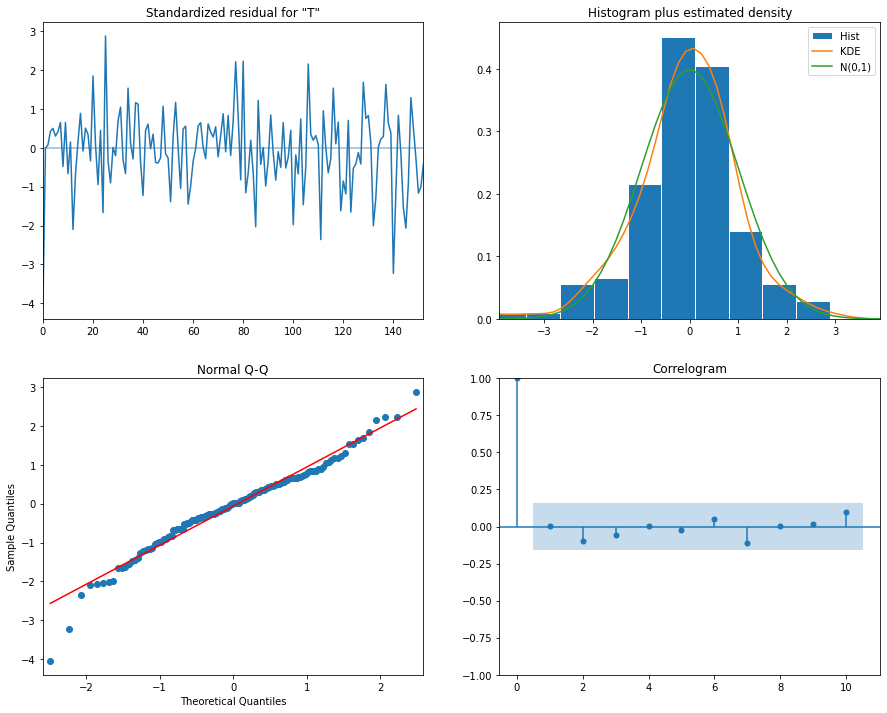

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 Total   No. Observations:                  165
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1303.999
Date:                               Mon, 27 Feb 2023   AIC                           2619.998
Time:                                       21:58:17   BIC                           2638.180
Sample:                                            0   HQIC                          2627.384
                                               - 165                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid        -68.9618     17.135     -4.025      0.000    -102.546     -35.378
ar.L1          0.9977      0.014     69.215      0.000       0.969       1.026
ma.L1         -0.2758      0.089     -3.100      0.002      -0.450      -0.101
ma.S.L12      -0.9493      0.112     -8.489      0.000      -1.169      -0.730
ma.S.L24      -0.0143      0.080     -0.178      0.859      -0.172       0.143
sigma2      1.265e+06      0.000   3.05e+09      0.000    1.27e+06    1.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.34
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.47
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+25. Standard errors may be unstable.
"""

In [17]:
best_mod = ARIMA(train["Total"], exog=train["covid"],
                 order=(1, 0, 1), seasonal_order=(0, 1, 2, 12))

best_res = best_mod.fit()

best_res.plot_diagnostics(figsize=(15, 12))
plt.show()
best_res.summary()

In [18]:
train_pred = pd.DataFrame(best_res.fittedvalues, columns=["train_pred"])
train_ci = best_res.get_prediction(dynamic=True).conf_int()

test_forecast = pd.DataFrame(best_res.forecast(steps=19, exog=test["covid"]))

test_ci = best_res.get_forecast(
    steps=19, exog=test["covid"], dynamic=True).conf_int()
ci = pd.concat([train_ci, test_ci], axis=0)

In [19]:
pred = pd.concat([train_pred, test_forecast]).reset_index().drop("index", axis=1)
mod_stats = pd.concat([pred, ci], axis=1)
palau_stats = pd.concat([palau, mod_stats], axis=1)
palau_stats

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,year,month,covid,train_pred,predicted_mean,lower Total,upper Total
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,0.000000,0.000000,NaN,-6024.556034,6024.556034
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.000000,5077.745630,NaN,-6024.556034,6024.556034
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.000000,6245.703527,NaN,-6024.556034,6024.556034
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.000000,7230.699391,NaN,-6024.556034,6024.556034
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.000000,6771.794560,NaN,-6024.556034,6024.556034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-05-01,101.0,16.0,2.0,5.0,541.0,18.0,68.0,751.0,2022.0,5.0,45.744435,NaN,-3094.359143,-9459.411686,3270.693399
180,2022-06-01,62.0,15.0,8.0,10.0,761.0,38.0,93.0,987.0,2022.0,6.0,36.033667,NaN,-1768.257146,-8338.797063,4802.282772
181,2022-07-01,96.0,8.0,15.0,9.0,708.0,127.0,137.0,1100.0,2022.0,7.0,26.947500,NaN,512.706314,-6255.615172,7281.027800
182,2022-08-01,99.0,17.0,82.0,5.0,375.0,133.0,125.0,836.0,2022.0,8.0,24.604718,NaN,1714.707651,-5243.689457,8673.104760


Text(0.5, 1.0, "Palau's Visitor Arrivals")

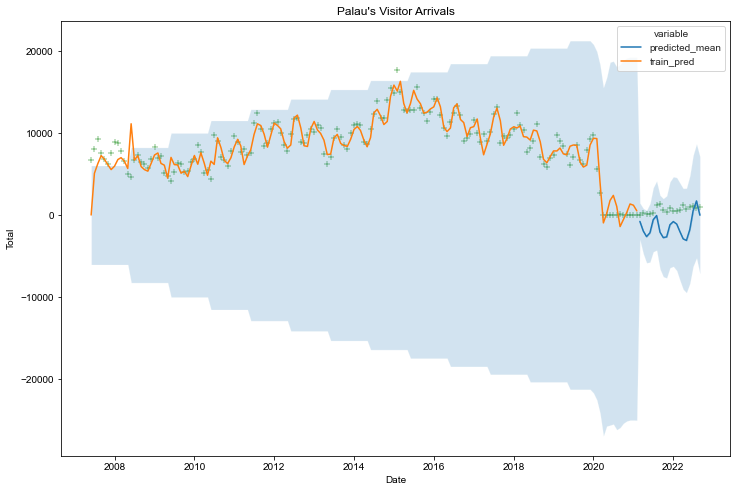

In [20]:
viz_df = palau_stats[["Date", "predicted_mean", "train_pred", "predicted_mean"]].melt(id_vars=["Date"])
viz_df["Date"] = pd.to_datetime(viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=palau_stats, color="green", marker="+")
ax.fill_between(x="Date", y1="lower Total", y2="upper Total", data=palau_stats, alpha=0.2)
sns.lineplot(data=viz_df, x="Date", y="value", hue="variable")
plt.title("Palau's Visitor Arrivals")